In [ ]:
%matplotlib widget

import os, glob, re
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import xrayutilities as xu

import ipywidgets as ipw
from ipywidgets import interact

import fabio
from silx.io.specfile import SpecFile

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import RectangleSelector

from lmfit import Model, Parameters

import warnings
warnings.filterwarnings('ignore')

## Functions

$$
\frac{1}{d_{hkl}^2} = \frac{1}{V^2} \left( h^2 b^2 c^2 \sin^2(\alpha) + k^2 c^2 a^2 \sin^2(\beta) + l^2 a^2 b^2 \sin^2(\gamma) 
+ 2hk abc^2 (\cos(\alpha) \cos(\beta) - \cos(\gamma)) 
+ 2kl bca^2 (\cos(\beta) \cos(\gamma) - \cos(\alpha)) 
+ 2lh cab^2 (\cos(\gamma) \cos(\alpha) - \cos(\beta)) \right)
$$


In [2]:
from pymatgen.core import Structure

# Load CIF file
cif_file = r'/Users/vthampy/Research/Structures/LaB6.cif'
structure = Structure.from_file(cif_file)

# Get lattice parameters
lattice = structure.lattice
a, b, c = lattice.a, lattice.b, lattice.c
alpha, beta, gamma = lattice.alpha, lattice.beta, lattice.gamma

print(f'Lattice constants: a = {a:.3f} Å, b = {b:.3f} Å, c = {c:.3f} Å')
print(f'Angles: alpha = {alpha:.3f}°, beta = {beta:.3f}°, gamma = {gamma:.3f}°')

Lattice constants: a = 4.157 Å, b = 4.157 Å, c = 4.157 Å
Angles: alpha = 90.000°, beta = 90.000°, gamma = 90.000°


# Working Code with BG

Parameters([('a', <Parameter 'a', value=3.3, bounds=[0:inf]>), ('b', <Parameter 'b', value=3.3, bounds=[0:inf]>), ('c', <Parameter 'c', value=3.3, bounds=[0:inf]>), ('alpha', <Parameter 'alpha', value=90, bounds=[0:inf]>), ('beta', <Parameter 'beta', value=90, bounds=[0:inf]>), ('gamma', <Parameter 'gamma', value=90, bounds=[0:inf]>), ('bg_c0', <Parameter 'bg_c0', value=0, bounds=[-inf:inf]>), ('bg_c1', <Parameter 'bg_c1', value=0, bounds=[-inf:inf]>), ('bg_c2', <Parameter 'bg_c2', value=0, bounds=[-inf:inf]>), ('bg_c3', <Parameter 'bg_c3', value=0, bounds=[-inf:inf]>), ('p1_amplitude', <Parameter 'p1_amplitude', value=1.4138432858890637, bounds=[0:inf]>), ('p1_sigma', <Parameter 'p1_sigma', value=0.1, bounds=[0:inf]>), ('p1_fraction', <Parameter 'p1_fraction', value=0.5, bounds=[0:1]>), ('p2_amplitude', <Parameter 'p2_amplitude', value=1.4138432858890637, bounds=[0:inf]>), ('p2_sigma', <Parameter 'p2_sigma', value=0.1, bounds=[0:inf]>), ('p2_fraction', <Parameter 'p2_fraction', value=

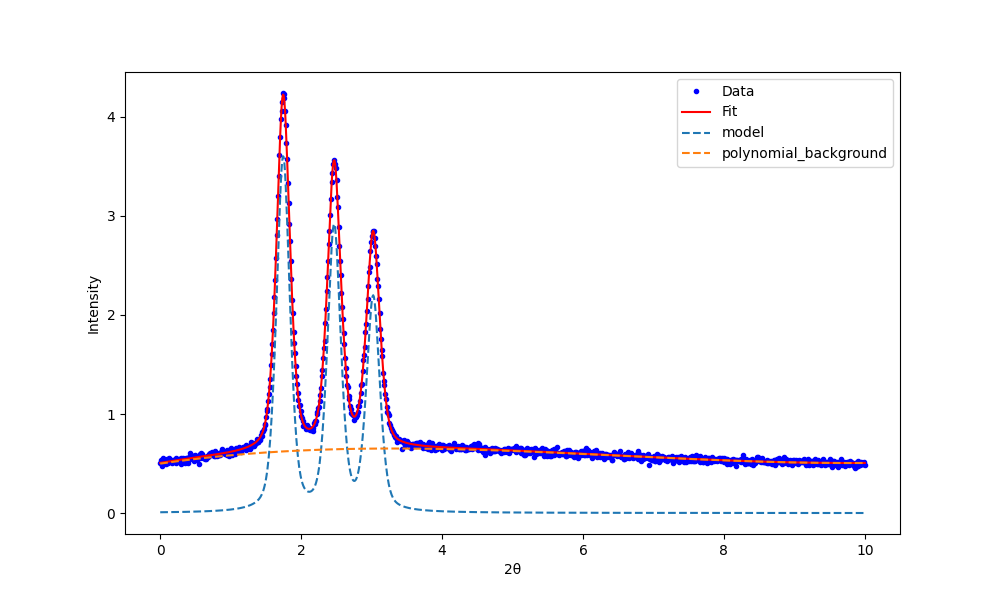

In [ ]:
def get_lattice_parameters(cif_file):
    try:
        structure = Structure.from_file(cif_file)
    except:
        return None
    
    lattice = structure.lattice
    a, b, c = lattice.a, lattice.b, lattice.c
    alpha, beta, gamma = lattice.alpha, lattice.beta, lattice.gamma
    
    return {'a': a, 'b': b, 'c': c, 'alpha': alpha, 'beta': beta, 'gamma': gamma}


def calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma):
    """
    Calculate the interplanar spacing (d-spacing) for given Miller indices and lattice parameters.
    
    Parameters:
    h, k, l: Miller indices
    a, b, c: Lattice parameters (lengths in Angstroms)
    alpha, beta, gamma: Lattice angles in degrees
    
    Returns:
    d: Interplanar spacing in Angstroms
    """
    # Convert angles to radians
    alpha_rad, beta_rad, gamma_rad = np.radians([alpha, beta, gamma])
    
    # Calculate required terms
    cos_alpha, cos_beta, cos_gamma = np.cos([alpha_rad, beta_rad, gamma_rad])
    sin_alpha, sin_beta, sin_gamma = np.sin([alpha_rad, beta_rad, gamma_rad])
    
    # Calculate volume of unit cell
    V = a * b * c * np.sqrt(1 - cos_alpha**2 - cos_beta**2 - cos_gamma**2 + 2 * cos_alpha * cos_beta * cos_gamma)
    
    # Calculate S parameters (reciprocal metric tensor components)
    S11 = (b**2 * c**2 * sin_alpha**2) / V**2
    S22 = (a**2 * c**2 * sin_beta**2) / V**2
    S33 = (a**2 * b**2 * sin_gamma**2) / V**2
    S12 = (a * b * c**2 * (cos_alpha * cos_beta - cos_gamma)) / V**2
    S23 = (a**2 * b * c * (cos_gamma * cos_alpha - cos_beta)) / V**2
    S13 = (a * b**2 * c * (cos_beta * cos_gamma - cos_alpha)) / V**2
    
    # Calculate d-spacing
    d_inv_squared = (h**2 * S11 + k**2 * S22 + l**2 * S33 + 2 * h * k * S12 + 2 * k * l * S23 + 2 * h * l * S13)
    return 1 / np.sqrt(d_inv_squared)

def calc_q_HKL(h, k, l, a, b, c, alpha, beta, gamma):
    return 2 * np.pi / calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma)

def calc_xrd_peak_position(d_spacing):
    return 2 * np.pi / d_spacing

def polynomial_background(x, **bg_params):
    return sum(bg_params[f'bg_c{i}'] * x**i for i in range(len(bg_params)) if f'bg_c{i}' in bg_params)

def create_peak_model(peak_type='gaussian'):
    if peak_type == 'gaussian':
        return lambda x, amplitude, center, sigma: amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))
    elif peak_type == 'lorentzian':
        return lambda x, amplitude, center, gamma: amplitude * gamma**2 / ((x - center)**2 + gamma**2)
    elif peak_type == 'pvoigt':
        def pvoigt(x, amplitude, center, sigma, fraction):
            g = np.exp(-(x - center)**2 / (2 * sigma**2))
            l = 1 / ((x - center)**2 + sigma**2)
            return amplitude * (fraction * g + (1 - fraction) * l)
        return pvoigt
    else:
        raise ValueError("Unsupported peak type")
    
    
def create_peak_model(peak_type='gaussian'):
    if peak_type == 'gaussian':
        # Gaussian defined with amplitude as peak area
        return lambda x, area, center, sigma: (area / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - center)**2 / (2 * sigma**2))
    
    elif peak_type == 'lorentzian':
        # Lorentzian defined with amplitude as peak area
        return lambda x, area, center, gamma: (area / (np.pi * gamma)) * (gamma**2 / ((x - center)**2 + gamma**2))
    
    elif peak_type == 'lorentzian_squared':
        # Lorentzian squared defined with amplitude as peak area
        # Scaling is adjusted to preserve the area based on the squared shape
        return lambda x, area, center, gamma: (area / (3 * np.pi * gamma)) * (gamma**2 / ((x - center)**2 + gamma**2))**2
    
    elif peak_type == 'pvoigt':
        # Pseudo-Voigt defined with amplitude as peak area
        def pvoigt(x, area, center, sigma, fraction):
            gaussian = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - center)**2 / (2 * sigma**2))
            lorentzian = 1 / (np.pi * sigma) / ((x - center)**2 / sigma**2 + 1)
            return area * (fraction * gaussian + (1 - fraction) * lorentzian)
        return pvoigt
    
    else:
        raise ValueError("Unsupported peak type")


def create_multi_peak_model(hkl_list, peak_type='gaussian'):
    def model(x, a, b, c, alpha, beta, gamma, **peak_params):
        result = np.zeros_like(x)
        for i, (h, k, l) in enumerate(hkl_list):
            d = calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma)
            center = calc_xrd_peak_position(d)
            peak = create_peak_model(peak_type)
            if peak_type == 'pvoigt':
                result += peak(x, peak_params[f'p{i+1}_amplitude'], center, peak_params[f'p{i+1}_sigma'], peak_params[f'p{i+1}_fraction'])
            else:
                result += peak(x, peak_params[f'p{i+1}_amplitude'], center, peak_params[f'p{i+1}_sigma'])
        return result
    return model

def fit_xrd_data(x_data, y_data, hkl_list, initial_params, bg_degree=3, peak_type='gaussian', constraints=None):
    model = Model(create_multi_peak_model(hkl_list, peak_type))
    model += Model(polynomial_background)
    params = Parameters()

    # Add lattice parameters
    for param, value in initial_params.items():
        params.add(param, value=value, min=0)

    # Add background parameters
    for i in range(bg_degree + 1):
        params.add(f'bg_c{i}', value=0)
        
    # Add peak parameters
    for i in range(len(hkl_list)):
        params.add(f'p{i+1}_amplitude', value=max(y_data)/len(hkl_list), min=0)
        params.add(f'p{i+1}_sigma', value=0.1, min=0)
        if peak_type == 'pvoigt':
            params.add(f'p{i+1}_fraction', value=0.5, min=0, max=1)

    print(params)
    
    # Apply constraints
    if constraints:
        for constraint in constraints:
            if constraint[0] == 'fix':
                params[constraint[1]].vary = False
            elif constraint[0] == 'range':
                params[constraint[1]].min = constraint[2]
                params[constraint[1]].max = constraint[3]
            elif constraint[0] == 'equal':
                params[constraint[2]].expr = constraint[1]

    result = model.fit(y_data, params, x=x_data)
    return result

# Example usage
# Generate synthetic data
x = np.linspace(0, 10, 1000)
hkl_list = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
true_params = {'a': 3.6, 'b': 3.6, 'c': 3.6, 'alpha': 90, 'beta': 90, 'gamma': 90}

func = 'pvoigt'
# Create the model function
model_func = create_multi_peak_model(hkl_list, func)

# Generate synthetic data using the model function
peak_params = {'p1_amplitude':1, 'p1_sigma':0.1, 'p1_fraction':0.5, 
               'p2_amplitude':0.8, 'p2_sigma':0.1, 'p2_fraction':0.5,
               'p3_amplitude':0.6, 'p3_sigma':0.1, 'p3_fraction':0.5}  # Amplitude, width and fraction for each peak
y = model_func(x, **true_params, **peak_params)
y += np.random.normal(0, 0.02, x.shape)  # Add some noise

# Generate polynomial background and add background to simulated data
bg_degree = 3
bg_coeffs = {f'bg_c{i}': coeff for i, coeff in enumerate([0.5, 0.1, -0.02, 0.001])}
background = polynomial_background(x, **bg_coeffs)

y += background

# Fit the data
initial_params = {'a': 3.3, 'b': 3.3, 'c': 3.3, 'alpha': 90, 'beta': 90, 'gamma': 90}
constraints = [
    ('range', 'a', 3.2, 3.8),
    ('equal', 'a', 'b'),
    ('equal', 'a', 'c'),
    ('fix', 'alpha'),
    ('fix', 'beta'),
    ('fix', 'gamma')
]
result = fit_xrd_data(x, y, hkl_list, initial_params, peak_type=func, constraints=constraints)

# Print results
print(result.fit_report())

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b.', label='Data')
plt.plot(x, result.best_fit, 'r-', label='Fit')

# Plot individual components
comps = result.eval_components(x=x)
for k, comp in comps.items():
    plt.plot(x, comp, '--', label=k)

plt.legend()
plt.xlabel('2θ')
plt.ylabel('Intensity')
plt.show()

# Working Code with BG

[[Model]]
    Model(model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 79
    # data points      = 1000
    # variables        = 12
    chi-square         = 0.40947506
    reduced chi-square = 4.1445e-04
    Akaike info crit   = -7776.63455
    Bayesian info crit = -7717.74148
    R-squared          = 0.99001459
[[Variables]]
    a:             3.60252303 +/- 9.2117e-04 (0.03%) (init = 3.5)
    b:             3.60252303 +/- 9.2117e-04 (0.03%) == 'a'
    c:             3.59813187 +/- 0.00450900 (0.13%) (init = 3.5)
    alpha:         90 (fixed)
    beta:          90 (fixed)
    gamma:         90 (fixed)
    bg_c0:         0.49848005 +/- 0.00260740 (0.52%) (init = 0)
    bg_c1:         0.10356287 +/- 0.00249012 (2.40%) (init = 0)
    bg_c2:        -0.02086435 +/- 5.9195e-04 (2.84%) (init = 0)
    bg_c3:         0.00105186 +/- 3.8705e-05 (3.68%) (init = 0)
    p1_amplitude:  1.00267807 +/- 0.00606117 (0.60%) (init = 0.5608851)
    p1_sigma:      0.09839264

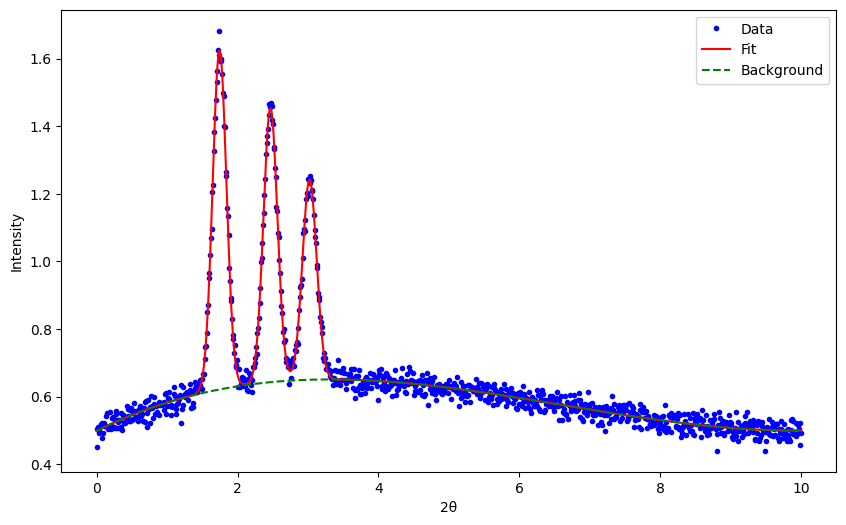

In [31]:
import numpy as np
from lmfit import Model, Parameters
import matplotlib.pyplot as plt

# ... (keep all the previous functions unchanged up to create_peak_model)
def calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma):
    """
    Calculate the interplanar spacing (d-spacing) for given Miller indices and lattice parameters.
    
    Parameters:
    h, k, l: Miller indices
    a, b, c: Lattice parameters (lengths in Angstroms)
    alpha, beta, gamma: Lattice angles in degrees
    
    Returns:
    d: Interplanar spacing in Angstroms
    """
    # Convert angles to radians
    alpha_rad, beta_rad, gamma_rad = np.radians([alpha, beta, gamma])
    
    # Calculate required terms
    cos_alpha, cos_beta, cos_gamma = np.cos([alpha_rad, beta_rad, gamma_rad])
    sin_alpha, sin_beta, sin_gamma = np.sin([alpha_rad, beta_rad, gamma_rad])
    
    # Calculate volume of unit cell
    V = a * b * c * np.sqrt(1 - cos_alpha**2 - cos_beta**2 - cos_gamma**2 + 2 * cos_alpha * cos_beta * cos_gamma)
    
    # Calculate S parameters (reciprocal metric tensor components)
    S11 = (b**2 * c**2 * sin_alpha**2) / V**2
    S22 = (a**2 * c**2 * sin_beta**2) / V**2
    S33 = (a**2 * b**2 * sin_gamma**2) / V**2
    S12 = (a * b * c**2 * (cos_alpha * cos_beta - cos_gamma)) / V**2
    S23 = (a**2 * b * c * (cos_gamma * cos_alpha - cos_beta)) / V**2
    S13 = (a * b**2 * c * (cos_beta * cos_gamma - cos_alpha)) / V**2
    
    # Calculate d-spacing
    d_inv_squared = (h**2 * S11 + k**2 * S22 + l**2 * S33 + 2 * h * k * S12 + 2 * k * l * S23 + 2 * h * l * S13)
    return 1 / np.sqrt(d_inv_squared)

def calc_xrd_peak_position(d_spacing):
    return 2 * np.pi / d_spacing

def polynomial_background(x, **bg_params):
    return sum(bg_params[f'bg_c{i}'] * x**i for i in range(len(bg_params)))

def create_peak_model(peak_type='gaussian'):
    if peak_type == 'gaussian':
        return lambda x, amplitude, center, sigma: amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))
    elif peak_type == 'lorentzian':
        return lambda x, amplitude, center, gamma: amplitude * gamma**2 / ((x - center)**2 + gamma**2)
    elif peak_type == 'pvoigt':
        def pvoigt(x, amplitude, center, sigma, fraction):
            g = np.exp(-(x - center)**2 / (2 * sigma**2))
            l = 1 / ((x - center)**2 + sigma**2)
            return amplitude * (fraction * g + (1 - fraction) * l)
        return pvoigt
    else:
        raise ValueError("Unsupported peak type")

def create_multi_peak_model_with_background(hkl_list, peak_type='gaussian'):
    def model(x, a, b, c, alpha, beta, gamma, **params):
        # Separate background coefficients from peak parameters
        bg_coeffs = {k: v for k, v in params.items() if k.startswith('bg_c')}
        peak_params = {k: v for k, v in params.items() if k.startswith('p')}
        
        # Calculate background
        background = polynomial_background(x, **bg_coeffs)
        
        # Calculate peaks
        result = np.zeros_like(x)
        for i, (h, k, l) in enumerate(hkl_list):
            d = calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma)
            center = calc_xrd_peak_position(d)
            peak = create_peak_model(peak_type)
            if peak_type == 'pvoigt':
                result += peak(x, peak_params[f'p{i+1}_amplitude'], center, peak_params[f'p{i+1}_sigma'], peak_params[f'p{i+1}_fraction'])
            else:
                result += peak(x, peak_params[f'p{i+1}_amplitude'], center, peak_params[f'p{i+1}_sigma'])
        
        # Combine background and peaks
        return background + result
    return model

def fit_xrd_data(x_data, y_data, hkl_list, initial_params, peak_type='gaussian', bg_degree=3, constraints=None):
    model = Model(create_multi_peak_model_with_background(hkl_list, peak_type))
    params = Parameters()

    # Add lattice parameters
    for param, value in initial_params.items():
        params.add(param, value=value, min=0)

    # Add background parameters
    for i in range(bg_degree + 1):
        params.add(f'bg_c{i}', value=0)

    # Add peak parameters
    for i in range(len(hkl_list)):
        params.add(f'p{i+1}_amplitude', value=max(y_data)/len(hkl_list), min=0)
        params.add(f'p{i+1}_sigma', value=0.1, min=0)
        if peak_type == 'pvoigt':
            params.add(f'p{i+1}_fraction', value=0.5, min=0, max=1)

    # Apply constraints
    if constraints:
        for constraint in constraints:
            if constraint[0] == 'fix':
                params[constraint[1]].vary = False
            elif constraint[0] == 'range':
                params[constraint[1]].min = constraint[2]
                params[constraint[1]].max = constraint[3]
            elif constraint[0] == 'equal':
                params[constraint[2]].expr = constraint[1]

    result = model.fit(y_data, params, x=x_data)
    return result

# Example usage
# Generate synthetic data
x = np.linspace(0, 10, 1000)
hkl_list = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
true_params = {'a': 3.6, 'b': 3.6, 'c': 3.6, 'alpha': 90, 'beta': 90, 'gamma': 90}

# Create the model function
bg_degree = 3
model_func = create_multi_peak_model_with_background(hkl_list, 'gaussian')

# Generate synthetic data using the model function
peak_params = {'p1_amplitude': 1, 'p1_sigma': 0.1,
               'p2_amplitude': 0.8, 'p2_sigma': 0.1,
               'p3_amplitude': 0.6, 'p3_sigma': 0.1}
bg_coeffs = {f'bg_c{i}': coeff for i, coeff in enumerate([0.5, 0.1, -0.02, 0.001])}

all_params = {**true_params, **peak_params, **bg_coeffs}
y = model_func(x, **all_params)
y += np.random.normal(0, 0.02, x.shape)  # Add some noise

# Fit the data
initial_params = {'a': 3.5, 'b': 3.5, 'c': 3.5, 'alpha': 90, 'beta': 90, 'gamma': 90}
constraints = [
    ('range', 'a', 3.4, 3.8),
    ('equal', 'a', 'b'),
    ('fix', 'alpha'),
    ('fix', 'beta'),
    ('fix', 'gamma')
]
result = fit_xrd_data(x, y, hkl_list, initial_params, 'gaussian', bg_degree, constraints)

# Print results
print(result.fit_report())

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b.', label='Data')
plt.plot(x, result.best_fit, 'r-', label='Fit')
fitted_bg_coeffs = {f'bg_c{i}': result.params[f'bg_c{i}'].value for i in range(bg_degree+1)}
plt.plot(x, polynomial_background(x, **fitted_bg_coeffs), 'g--', label='Background')
plt.legend()
plt.xlabel('2θ')
plt.ylabel('Intensity')
plt.show()

In [72]:
def create_gaussian_peak(x, amplitude, center, sigma):
    return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))

def create_lorentzian_peak(x, amplitude, center, gamma):
    return amplitude * gamma**2 / ((x - center)**2 + gamma**2)

def create_pvoigt_peak(x, amplitude, center, sigma, fraction):
    g = np.exp(-(x - center)**2 / (2 * sigma**2))
    l = 1 / ((x - center)**2 + sigma**2)
    return amplitude * (fraction * g + (1 - fraction) * l)

def create_peak_model(peak_type='gaussian'):
    if peak_type == 'gaussian':
        return create_gaussian_peak
    elif peak_type == 'lorentzian':
        return create_lorentzian_peak
    elif peak_type == 'pvoigt':
        return create_pvoigt_peak
    else:
        raise ValueError("Unsupported peak type")

def create_multi_peak_model(hkl_list, peak_type='gaussian'):
    peak_functions = []
    for i, (h, k, l) in enumerate(hkl_list):
        peak_func = create_peak_model(peak_type)
        peak_functions.append(peak_func)
    
    def model(x, a, b, c, alpha, beta, gamma, **peak_params):
        result = np.zeros_like(x)
        for i, (h, k, l) in enumerate(hkl_list):
            d = calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma)
            center = calc_xrd_peak_position(d)
            if peak_type == 'pvoigt':
                result += peak_functions[i](x, peak_params[f'p{i+1}_amplitude'], center, peak_params[f'p{i+1}_sigma'], peak_params[f'p{i+1}_fraction'])
            else:
                result += peak_functions[i](x, peak_params[f'p{i+1}_amplitude'], center, peak_params[f'p{i+1}_sigma'])
        return result
    
    return model

def polynomial_background(x, **bg_params):
    return sum(bg_params[f'bg_c{i}'] * x**i for i in range(len(bg_params)) if f'bg_c{i}' in bg_params)

def fit_xrd_data(x_data, y_data, hkl_list, initial_params, bg_degree=3, peak_type='gaussian', constraints=None):
    peak_model = Model(create_multi_peak_model(hkl_list, peak_type))
    bg_model = Model(polynomial_background, independent_vars=['x'])
    full_model = peak_model + bg_model
    
    params = full_model.make_params()
    
    # Initialize params with initial_params
    for key, value in initial_params.items():
        params[key].set(value=value)
    
    # Apply constraints if provided
    if constraints:
        for param_name, constraint_dict in constraints.items():
            for attr, val in constraint_dict.items():
                getattr(params[param_name], attr).set(val)
    
    result = full_model.fit(y_data, params, x=x_data)
    return result


bg_model = Model(polynomial_background, independent_vars=['x'])

peak_type = 'gaussian'
hkl_list = [(1, 0, 0)]

peak_model = Model(create_multi_peak_model(hkl_list, peak_type))

hkl_list = [(1, 1, 0), (1, 1, 1)]
peak_model += Model(create_multi_peak_model(hkl_list, peak_type))


NameError: 
Two models have parameters named 'a'; use distinct names.
Two models have parameters named 'gamma'; use distinct names.
Two models have parameters named 'c'; use distinct names.
Two models have parameters named 'beta'; use distinct names.
Two models have parameters named 'alpha'; use distinct names.
Two models have parameters named 'b'; use distinct names.

In [ ]:



# Example usage
# Generate synthetic data
x = np.linspace(0, 10, 1000)
hkl_list = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
true_params = {'a': 3.6, 'b': 3.6, 'c': 3.6, 'alpha': 90, 'beta': 90, 'gamma': 90}

func = 'pvoigt'
# Create the model function
model_func = create_multi_peak_model(hkl_list, func)

# Generate synthetic data using the model function
peak_params = {'p1_amplitude':1, 'p1_sigma':0.1, 'p1_fraction':0.5, 
               'p2_amplitude':0.8, 'p2_sigma':0.1, 'p2_fraction':0.5,
               'p3_amplitude':0.6, 'p3_sigma':0.1, 'p3_fraction':0.5}  # Amplitude, width and fraction for each peak
y = model_func(x, **true_params, **peak_params)
y += np.random.normal(0, 0.02, x.shape)  # Add some noise

# Generate polynomial background and add background to simulated data
bg_degree = 3
bg_coeffs = {f'bg_c{i}': coeff for i, coeff in enumerate([0.5, 0.1, -0.02, 0.001])}
background = polynomial_background(x, **bg_coeffs)

y += background

# Fit the data
initial_params = {'a': 3.3, 'b': 3.3, 'c': 3.3, 'alpha': 90, 'beta': 90, 'gamma': 90}
constraints = [
    ('range', 'a', 3.2, 3.8),
    ('equal', 'a', 'b'),
    ('equal', 'a', 'c'),
    ('fix', 'alpha'),
    ('fix', 'beta'),
    ('fix', 'gamma')
]

Parameters([('bg_c0', <Parameter 'bg_c0', value=0, bounds=[-inf:inf]>), ('bg_c1', <Parameter 'bg_c1', value=0, bounds=[-inf:inf]>), ('bg_c2', <Parameter 'bg_c2', value=0, bounds=[-inf:inf]>), ('bg_c3', <Parameter 'bg_c3', value=0, bounds=[-inf:inf]>), ('p0_amplitude', <Parameter 'p0_amplitude', value=0.5476884617145412, bounds=[0:inf]>), ('p0_sigma', <Parameter 'p0_sigma', value=0.1, bounds=[0:inf]>), ('p0_a', <Parameter 'p0_a', value=-inf, bounds=[-inf:inf]>), ('p0_b', <Parameter 'p0_b', value=-inf, bounds=[-inf:inf]>), ('p0_c', <Parameter 'p0_c', value=-inf, bounds=[-inf:inf]>), ('p0_alpha', <Parameter 'p0_alpha', value=-inf, bounds=[-inf:inf]>), ('p0_beta', <Parameter 'p0_beta', value=-inf, bounds=[-inf:inf]>), ('p0_gamma', <Parameter 'p0_gamma', value=-inf, bounds=[-inf:inf]>), ('p1_amplitude', <Parameter 'p1_amplitude', value=0.5476884617145412, bounds=[0:inf]>), ('p1_sigma', <Parameter 'p1_sigma', value=0.1, bounds=[0:inf]>), ('p1_a', <Parameter 'p1_a', value=-inf, bounds=[-inf:i

ValueError: 'Missing independent variable 'fraction'

Parameters([('peak0_center', <Parameter 'peak0_center', value=1.698158191129618, bounds=[-inf:inf]>), ('peak1_center', <Parameter 'peak1_center', value=2.401558344950468, bounds=[-inf:inf]>), ('peak2_center', <Parameter 'peak2_center', value=2.9412962663257582, bounds=[-inf:inf]>), ('a', <Parameter 'a', value=3.7, bounds=[0:inf]>), ('b', <Parameter 'b', value=3.7, bounds=[0:inf]>), ('c', <Parameter 'c', value=3.7, bounds=[0:inf]>), ('alpha', <Parameter 'alpha', value=90, bounds=[0:inf]>), ('beta', <Parameter 'beta', value=90, bounds=[0:inf]>), ('gamma', <Parameter 'gamma', value=90, bounds=[0:inf]>), ('bg_c0', <Parameter 'bg_c0', value=0, bounds=[-inf:inf]>), ('bg_c1', <Parameter 'bg_c1', value=0, bounds=[-inf:inf]>), ('bg_c2', <Parameter 'bg_c2', value=0, bounds=[-inf:inf]>), ('bg_c3', <Parameter 'bg_c3', value=0, bounds=[-inf:inf]>), ('peak0_amplitude', <Parameter 'peak0_amplitude', value=0.5485503455978525, bounds=[0:inf]>), ('peak0_sigma', <Parameter 'peak0_sigma', value=0.1, bound

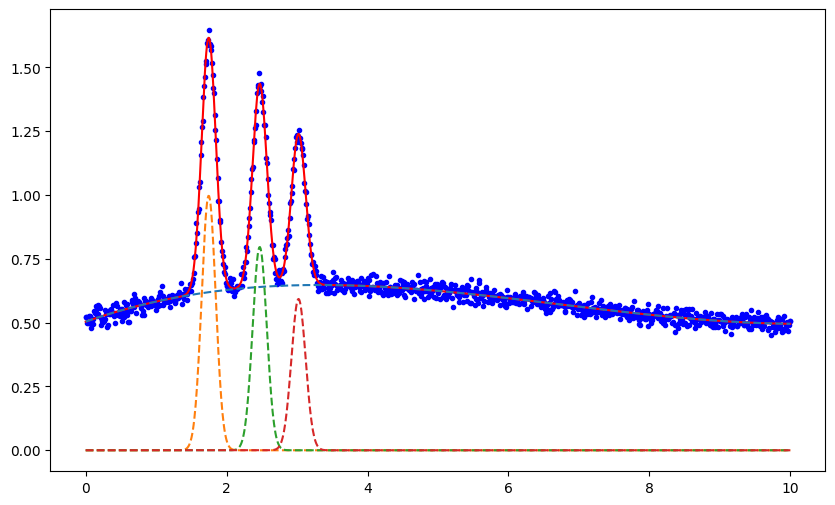

In [60]:
import numpy as np
from lmfit import Model, Parameters
import matplotlib.pyplot as plt

def calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma):
    """
    Calculate the interplanar spacing (d-spacing) for given Miller indices and 
    lattice parameters.
    
    Parameters:
    h, k, l: Miller indices
    a, b, c: Lattice parameters (lengths in Angstroms)
    alpha, beta, gamma: Lattice angles in degrees
    
    Returns:
    d: Interplanar spacing in Angstroms
    """
    alpha_rad, beta_rad, gamma_rad = np.radians([alpha, beta, gamma])
    cos_alpha, cos_beta, cos_gamma = np.cos([alpha_rad, beta_rad, gamma_rad])
    sin_alpha, sin_beta, sin_gamma = np.sin([alpha_rad, beta_rad, gamma_rad])

    V = a * b * c * np.sqrt(1 - cos_alpha**2 - cos_beta**2 - cos_gamma**2 + 2 * cos_alpha * cos_beta * cos_gamma)
    
    S11 = (b**2 * c**2 * sin_alpha**2) / V**2
    S22 = (a**2 * c**2 * sin_beta**2) / V**2
    S33 = (a**2 * b**2 * sin_gamma**2) / V**2
    S12 = (a * b * c**2 * (cos_alpha * cos_beta - cos_gamma)) / V**2
    S23 = (a**2 * b * c * (cos_gamma * cos_alpha - cos_beta)) / V**2
    S13 = (a * b**2 * c * (cos_beta * cos_gamma - cos_alpha)) / V**2
    
    d_inv_squared = (h**2 * S11 + k**2 * S22 + l**2 * S33 + 2 * (h * k * S12 + k * l * S23 + h * l * S13))
    return 1 / np.sqrt(d_inv_squared)

def calc_xrd_peak_position(d_spacing):
    return 2 * np.pi / d_spacing

def polynomial_background(x, **bg_params):
    return sum(bg_params[f'bg_c{i}'] * x**i for i in range(len(bg_params)) if f'bg_c{i}' in bg_params)

def create_peak_model(peak_type='gaussian'):
    if peak_type == 'gaussian':
        return lambda x, amplitude, center, sigma: amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))
    elif peak_type == 'lorentzian':
        return lambda x, amplitude, center, gamma: amplitude * gamma**2 / ((x - center)**2 + gamma**2)
    elif peak_type == 'pvoigt':
        def pvoigt(x, amplitude, center, sigma, fraction):
            g = np.exp(-(x - center)**2 / (2 * sigma**2))
            l = 1 / ((x - center)**2 + sigma**2)
            return amplitude * (fraction * g + (1 - fraction) * l)
        return pvoigt
    else:
        raise ValueError("Unsupported peak type")

def fit_xrd_data(x_data, y_data, hkl_list, initial_params, bg_degree=3, peak_type='gaussian', constraints=None):
    # Initialize parameters
    params = Parameters()

    # Create a model for each peak
    peak_models = []
    for i, (h, k, l) in enumerate(hkl_list):
        peak_model = Model(create_peak_model(peak_type), prefix=f'peak{i}_')
        peak_pos = calc_xrd_peak_position(calculate_d_spacing(h, k, l, 
                                                            initial_params['a'], 
                                                            initial_params['b'], 
                                                            initial_params['c'], 
                                                            initial_params['alpha'], 
                                                            initial_params['beta'], 
                                                            initial_params['gamma']))
        params.add(f'peak{i}_center', value=peak_pos)
        
        peak_model.set_param_hint(f'peak{i}_center', value=peak_pos, vary=True)
        peak_models.append(peak_model)

    # Create the polynomial background model
    bg_model = Model(polynomial_background)

    # Combine all models
    model = bg_model
    for peak_model in peak_models:
        model += peak_model


    # Add lattice parameters
    for param, value in initial_params.items():
        params.add(param, value=value, min=0)

    # Add background parameters
    for i in range(bg_degree + 1):
        params.add(f'bg_c{i}', value=0)

    # Add peak parameters
    for i in range(len(hkl_list)):
        params.add(f'peak{i}_amplitude', value=max(y_data)/len(hkl_list), min=0)
        params.add(f'peak{i}_sigma', value=0.1, min=0)
        if peak_type == 'pvoigt':
            params.add(f'peak{i}_fraction', value=0.5, min=0, max=1)

    print(params)
    # Apply constraints
    if constraints:
        for constraint in constraints:
            if constraint[0] == 'fix':
                params[constraint[1]].vary = False
            elif constraint[0] == 'range':
                params[constraint[1]].min = constraint[2]
                params[constraint[1]].max = constraint[3]
            elif constraint[0] == 'equal':
                params[constraint[2]].expr = constraint[1]

    result = model.fit(y_data, params, x=x_data)
    return result

# Example usage
# Generate synthetic data
x = np.linspace(0, 10, 1000)
hkl_list = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
true_params = {'a': 3.6, 'b': 3.6, 'c': 3.6, 'alpha': 90, 'beta': 90, 'gamma': 90}

# Generate synthetic data using the model function
peak_params = {
    'peak0_amplitude': 1, 'peak0_sigma': 0.1, 
    'peak1_amplitude': 0.8, 'peak1_sigma': 0.1, 
    'peak2_amplitude': 0.6, 'peak2_sigma': 0.1
}  
y = np.zeros_like(x)
for i, (h, k, l) in enumerate(hkl_list):
    peak_pos = calc_xrd_peak_position(calculate_d_spacing(h, k, l, **true_params))
    peak = create_peak_model('gaussian')
    y += peak(x, peak_params[f'peak{i}_amplitude'], peak_pos, peak_params[f'peak{i}_sigma'])

# Generate polynomial background and add background to simulated data
bg_degree = 3
bg_coeffs = {f'bg_c{i}': coeff for i, coeff in enumerate([0.5, 0.1, -0.02, 0.001])}
background = polynomial_background(x, **bg_coeffs)
y += background
y += np.random.normal(0, 0.02, x.shape)  # Add some noise

# Fit the data
initial_params = {'a': 3.7, 'b': 3.7, 'c': 3.7, 'alpha': 90, 'beta': 90, 'gamma': 90}
constraints = [
    ('range', 'a', 3.4, 3.8),
    ('equal', 'a', 'b'),
    ('fix', 'alpha'),
    ('fix', 'beta'),
    ('fix', 'gamma')
]
result = fit_xrd_data(x, y, hkl_list, initial_params, peak_type='gaussian', constraints=constraints)

# Print results
print(result.fit_report())

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b.', label='Data')
plt.plot(x, result.best_fit, 'r-', label='Fit')


# Plot individual components
comps = result.eval_components(x=x)
for k, comp in comps.items():
    plt.plot(x, comp, '--', label=k)

# Plot

[[Model]]
    (((Model(polynomial_background, prefix='bg_') + Model(<lambda>, prefix='p0_')) + Model(<lambda>, prefix='p1_')) + Model(<lambda>, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 586
    # data points      = 1000
    # variables        = 12
    chi-square         = 11.4658391
    reduced chi-square = 0.01160510
    Akaike info crit   = -4444.38317
    Bayesian info crit = -4385.49011
    R-squared          = 0.71847800
##  Warning: uncertainties could not be estimated:
    a:             at initial value
    c:             at initial value
[[Variables]]
    p0_center:     1.795196 (fixed)
    p0_amplitude:  0.81499543 (init = 1)
    p0_sigma:      0.09618469 (init = 0.1)
    p1_center:     2.53879 (fixed)
    p1_amplitude:  0.37205709 (init = 1)
    p1_sigma:      0.46218588 (init = 0.1)
    p2_center:     3.10937 (fixed)
    p2_amplitude:  0.62185272 (init = 1)
    p2_sigma:      9.26297890 (init = 0.1)
    bg_c0:         0.0000

ValueError: x and y must have same first dimension, but have shapes (1000,) and (1,)

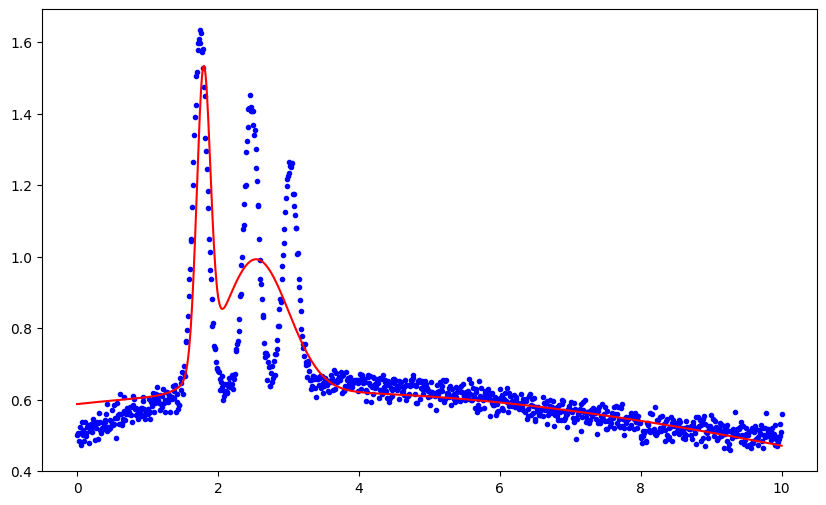

In [58]:
import numpy as np
from lmfit import Model, Parameters
import matplotlib.pyplot as plt

def calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma):
    """
    Calculate the interplanar spacing (d-spacing) for given Miller indices and lattice parameters.
    """
    alpha_rad, beta_rad, gamma_rad = np.radians([alpha, beta, gamma])
    cos_alpha, cos_beta, cos_gamma = np.cos([alpha_rad, beta_rad, gamma_rad])
    sin_alpha, sin_beta, sin_gamma = np.sin([alpha_rad, beta_rad, gamma_rad])

    V = a * b * c * np.sqrt(1 - cos_alpha**2 - cos_beta**2 - cos_gamma**2 + 
                            2 * cos_alpha * cos_beta * cos_gamma)
    
    S11 = (b**2 * c**2 * sin_alpha**2) / V**2
    S22 = (a**2 * c**2 * sin_beta**2) / V**2
    S33 = (a**2 * b**2 * sin_gamma**2) / V**2
    S12 = (a * b * c**2 * (cos_alpha * cos_beta - cos_gamma)) / V**2
    S23 = (a**2 * b * c * (cos_gamma * cos_alpha - cos_beta)) / V**2
    S13 = (a * b**2 * c * (cos_beta * cos_gamma - cos_alpha)) / V**2
    
    d_inv_squared = (h**2 * S11 + k**2 * S22 + l**2 * S33 + 2 * (h * k * S12 + k * l * S23 + h * l * S13))
    return 1 / np.sqrt(d_inv_squared)

def calc_xrd_peak_position(d_spacing):
    """
    Calculate the XRD peak position in reciprocal space for a given d-spacing.
    """
    return 2 * np.pi / d_spacing

def polynomial_background(x, **bg_params):
    """
    Polynomial background function.
    """
    return sum(bg_params[f'bg_c{i}'] * x**i for i in range(len(bg_params)) if f'bg_c{i}' in bg_params)

def create_peak_model(peak_type='gaussian'):
    """
    Factory function to create a specified peak model (gaussian, lorentzian, or pvoigt).
    """
    if peak_type == 'gaussian':
        return lambda x, amplitude, center, sigma: amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))
    elif peak_type == 'lorentzian':
        return lambda x, amplitude, center, gamma: amplitude * gamma**2 / ((x - center)**2 + gamma**2)
    elif peak_type == 'pvoigt':
        def pvoigt(x, amplitude, center, sigma, fraction):
            g = np.exp(-(x - center)**2 / (2 * sigma**2))
            l = 1 / ((x - center)**2 + sigma**2)
            return amplitude * (fraction * g + (1 - fraction) * l)
        return pvoigt
    else:
        raise ValueError("Unsupported peak type")

def initialize_peak_models(hkl_list, initial_params, peak_type='gaussian'):
    """
    Create and initialize individual peak models for each entry in hkl_list.
    """
    peak_models = []
    params = Parameters()
    
    for i, (h, k, l) in enumerate(hkl_list):
        peak_prefix = f'p{i}_'
        peak_model = Model(create_peak_model(peak_type), prefix=peak_prefix)
        
        # Calculate initial peak position based on d-spacing
        peak_pos = calc_xrd_peak_position(calculate_d_spacing(h, k, l, 
                                                              initial_params['a'], 
                                                              initial_params['b'], 
                                                              initial_params['c'], 
                                                              initial_params['alpha'], 
                                                              initial_params['beta'], 
                                                              initial_params['gamma']))
        
        # Set initial peak parameters
        params.add(f'{peak_prefix}center', value=peak_pos, vary=False)
        params.add(f'{peak_prefix}amplitude', value=1.0, min=0)
        params.add(f'{peak_prefix}sigma', value=0.1, min=0)
        if peak_type == 'pvoigt':
            params.add(f'{peak_prefix}fraction', value=0.5, min=0, max=1)
        
        peak_models.append(peak_model)
    
    return peak_models, params

def initialize_background_model(bg_degree):
    """
    Initialize the polynomial background model with the specified degree.
    """
    bg_model = Model(polynomial_background, prefix='bg_')
    params = Parameters()
    
    for i in range(bg_degree + 1):
        params.add(f'bg_c{i}', value=0)
    
    return bg_model, params

def apply_constraints(params, constraints):
    """
    Apply constraints to the fitting parameters.
    """
    if constraints:
        for constraint in constraints:
            if constraint[0] == 'fix':
                params[constraint[1]].vary = False
            elif constraint[0] == 'range':
                params[constraint[1]].min = constraint[2]
                params[constraint[1]].max = constraint[3]
            elif constraint[0] == 'equal':
                params[constraint[2]].expr = constraint[1]

def fit_xrd_data(x_data, y_data, hkl_list, initial_params, bg_degree=3, peak_type='gaussian', constraints=None):
    """
    Fit XRD data with a model consisting of individual peaks and a polynomial background.
    """
    # Initialize peak models and background model
    peak_models, peak_params = initialize_peak_models(hkl_list, initial_params, peak_type=peak_type)
    background_model, bg_params = initialize_background_model(bg_degree)

    # Combine background model with all peak models
    model = background_model
    for peak_model in peak_models:
        model += peak_model
    params = peak_params + bg_params

    # Set lattice parameters for peaks
    for param, value in initial_params.items():
        params.add(param, value=value, min=0)

    # Apply constraints
    apply_constraints(params, constraints)

    # Perform the fit
    result = model.fit(y_data, params, x=x_data)
    return result

# Example usage
x = np.linspace(0, 10, 1000)
hkl_list = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
true_params = {'a': 3.6, 'b': 3.6, 'c': 3.6, 'alpha': 90, 'beta': 90, 'gamma': 90}

# Generate synthetic peaks
peak_params = {
    'p0_amplitude': 1, 'p0_sigma': 0.1, 
    'p1_amplitude': 0.8, 'p1_sigma': 0.1, 
    'p2_amplitude': 0.6, 'p2_sigma': 0.1
}  
y = np.zeros_like(x)
for i, (h, k, l) in enumerate(hkl_list):
    peak_pos = calc_xrd_peak_position(calculate_d_spacing(h, k, l, **true_params))
    peak = create_peak_model('gaussian')
    y += peak(x, peak_params[f'p{i}_amplitude'], peak_pos, peak_params[f'p{i}_sigma'])

# Generate and add polynomial background to synthetic data
bg_degree = 3
bg_coeffs = {f'bg_c{i}': coeff for i, coeff in enumerate([0.5, 0.1, -0.02, 0.001])}
background = polynomial_background(x, **bg_coeffs)
y += background
y += np.random.normal(0, 0.02, x.shape)  # Add some noise

# Fit the data
initial_params = {'a': 3.5, 'b': 3.5, 'c': 3.5, 'alpha': 90, 'beta': 90, 'gamma': 90}
constraints = [
    ('range', 'a', 3.4, 3.8),
    ('equal', 'a', 'b'),
    ('fix', 'alpha'),
    ('fix', 'beta'),
    ('fix', 'gamma')
]
result = fit_xrd_data(x, y, hkl_list, initial_params, bg_degree, peak_type='gaussian', constraints=constraints)

# Print fit report
print(result.fit_report())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b.', label='Data')
plt.plot(x, result.best_fit, 'r-', label='Fit')

# Plot individual components
for k, comp in result.eval_components(x=x).items():
    plt.plot(x, comp, '--', label=k)

plt.xlabel('2θ')
plt.ylabel('Intensity')
plt.legend()
plt.show()

Parameters([('a', <Parameter 'a', value=3.5, bounds=[0:inf]>), ('b', <Parameter 'b', value=3.5, bounds=[0:inf]>), ('c', <Parameter 'c', value=3.5, bounds=[0:inf]>), ('alpha', <Parameter 'alpha', value=90, bounds=[0:inf]>), ('beta', <Parameter 'beta', value=90, bounds=[0:inf]>), ('gamma', <Parameter 'gamma', value=90, bounds=[0:inf]>), ('bg_c0', <Parameter 'bg_c0', value=0, bounds=[-inf:inf]>), ('bg_c1', <Parameter 'bg_c1', value=0, bounds=[-inf:inf]>), ('bg_c2', <Parameter 'bg_c2', value=0, bounds=[-inf:inf]>), ('bg_c3', <Parameter 'bg_c3', value=0, bounds=[-inf:inf]>), ('p1_amplitude', <Parameter 'p1_amplitude', value=0.5473654768876858, bounds=[0:inf]>), ('p1_sigma', <Parameter 'p1_sigma', value=0.1, bounds=[0:inf]>), ('p2_amplitude', <Parameter 'p2_amplitude', value=0.5473654768876858, bounds=[0:inf]>), ('p2_sigma', <Parameter 'p2_sigma', value=0.1, bounds=[0:inf]>), ('p3_amplitude', <Parameter 'p3_amplitude', value=0.5473654768876858, bounds=[0:inf]>), ('p3_sigma', <Parameter 'p3_s

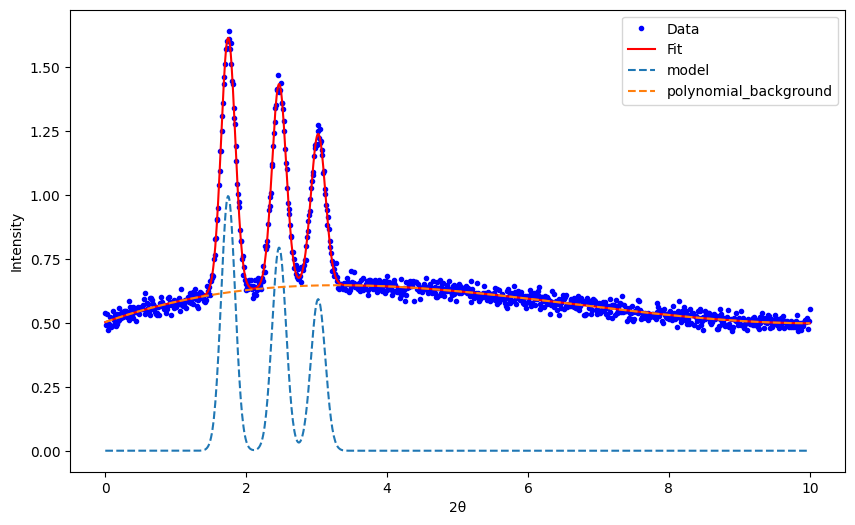

[[Model]]
    Model(model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 79
    # data points      = 1000
    # variables        = 12
    chi-square         = 0.40947506
    reduced chi-square = 4.1445e-04
    Akaike info crit   = -7776.63455
    Bayesian info crit = -7717.74148
    R-squared          = 0.99001459
[[Variables]]
    a:             3.60252303 +/- 9.2117e-04 (0.03%) (init = 3.5)
    b:             3.60252303 +/- 9.2117e-04 (0.03%) == 'a'
    c:             3.59813187 +/- 0.00450900 (0.13%) (init = 3.5)
    alpha:         90 (fixed)
    beta:          90 (fixed)
    gamma:         90 (fixed)
    bg_c0:         0.49848005 +/- 0.00260740 (0.52%) (init = 0)
    bg_c1:         0.10356287 +/- 0.00249012 (2.40%) (init = 0)
    bg_c2:        -0.02086435 +/- 5.9195e-04 (2.84%) (init = 0)
    bg_c3:         0.00105186 +/- 3.8705e-05 (3.68%) (init = 0)
    p1_amplitude:  1.00267807 +/- 0.00606117 (0.60%) (init = 0.5608851)
    p1_sigma:      0.09839264

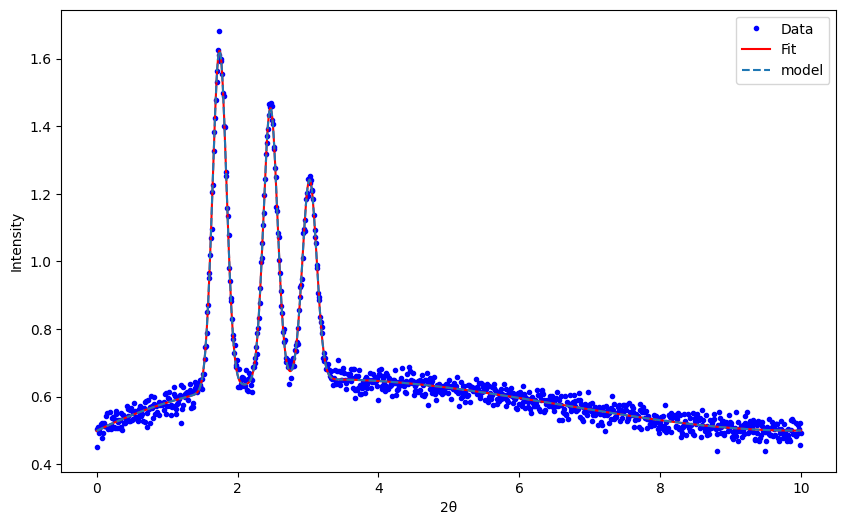

In [33]:
result.components

[Model(model)]

In [17]:
import numpy as np
from lmfit import Model, CompositeModel, Parameters
import matplotlib.pyplot as plt

# ... (keep the calculate_d_spacing and calc_xrd_peak_position functions unchanged)

def gaussian(x, amplitude, center, sigma):
    return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))

def polynomial_background(x, c0, c1, c2, c3):
    return c0 + c1*x + c2*x**2 + c3*x**3

def create_peak_model(hkl, a, b, c, alpha, beta, gamma):
    h, k, l = hkl
    d = calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma)
    center = calc_xrd_peak_position(d)
    
    def peak_model(x, amplitude, sigma):
        return gaussian(x, amplitude, center, sigma)
    
    return Model(peak_model, prefix=f'p{h}{k}{l}_')

def create_multi_peak_model_with_background(hkl_list, a, b, c, alpha, beta, gamma):
    bg_model = Model(polynomial_background, prefix='bg_')
    
    peak_models = [create_peak_model(hkl, a, b, c, alpha, beta, gamma) for hkl in hkl_list]
    
    model = bg_model
    for peak_model in peak_models:
        model += peak_model
    
    return model

def fit_xrd_data(x_data, y_data, hkl_list, initial_params, constraints=None):
    a, b, c = initial_params['a'], initial_params['b'], initial_params['c']
    alpha, beta, gamma = initial_params['alpha'], initial_params['beta'], initial_params['gamma']
    
    model = create_multi_peak_model_with_background(hkl_list, a, b, c, alpha, beta, gamma)
    params = model.make_params()
    
    # Set initial values and bounds for background parameters
    params['bg_c0'].set(value=min(y_data), min=0)
    params['bg_c1'].set(value=0)
    params['bg_c2'].set(value=0)
    params['bg_c3'].set(value=0)
    
    # Set initial values and bounds for peak parameters
    for hkl in hkl_list:
        prefix = f'p{"".join(map(str, hkl))}_'
        params[f'{prefix}amplitude'].set(value=max(y_data)/len(hkl_list), min=0)
        params[f'{prefix}sigma'].set(value=0.1, min=0)
    
    print(params, constraints)
    # Apply constraints
    if constraints:
        for constraint in constraints:
            if constraint[0] == 'fix':
                params[constraint[1]].vary = False
            elif constraint[0] == 'range':
                params[constraint[1]].min = constraint[2]
                params[constraint[1]].max = constraint[3]
            elif constraint[0] == 'equal':
                params[constraint[2]].expr = constraint[1]

    result = model.fit(y_data, params, x=x_data)
    return result

# Example usage
# Generate synthetic data
x = np.linspace(0, 10, 1000)
hkl_list = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
true_params = {'a': 3.6, 'b': 3.6, 'c': 3.6, 'alpha': 90, 'beta': 90, 'gamma': 90}

# Create the model function
model_func = create_multi_peak_model_with_background(hkl_list, **true_params)

# Generate synthetic data
peak_params = {'p100_amplitude': 1, 'p100_sigma': 0.1,
               'p110_amplitude': 0.8, 'p110_sigma': 0.1,
               'p111_amplitude': 0.6, 'p111_sigma': 0.1}
bg_params = {'bg_c0': 0.5, 'bg_c1': 0.1, 'bg_c2': -0.02, 'bg_c3': 0.001}

all_params = {**true_params, **peak_params, **bg_params}
y = model_func.eval(x=x, **all_params)
y += np.random.normal(0, 0.02, x.shape)  # Add some noise

# Fit the data
initial_params = {'a': 3.5, 'b': 3.5, 'c': 3.5, 'alpha': 90, 'beta': 90, 'gamma': 90}
constraints = [
    ('range', 'p100_amplitude', 0, 2),
    ('fix', 'alpha'),
    ('fix', 'beta'),
    ('fix', 'gamma')
]
result = fit_xrd_data(x, y, hkl_list, initial_params, constraints)

# Print results
print(result.fit_report())

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b.', label='Data')
plt.plot(x, result.best_fit, 'r-', label='Fit')

# Plot individual components
comps = result.eval_components(x=x)
plt.plot(x, comps['bg_'], 'g--', label='Background')
for hkl in hkl_list:
    plt.plot(x, comps[f'p{"".join(map(str, hkl))}_'], '--', label=f'Peak {hkl}')

plt.legend()
plt.xlabel('2θ')
plt.ylabel('Intensity')
plt.show()

Parameters([('bg_c0', <Parameter 'bg_c0', value=0.4487799064950692, bounds=[0:inf]>), ('bg_c1', <Parameter 'bg_c1', value=0, bounds=[-inf:inf]>), ('bg_c2', <Parameter 'bg_c2', value=0, bounds=[-inf:inf]>), ('bg_c3', <Parameter 'bg_c3', value=0, bounds=[-inf:inf]>), ('p100_amplitude', <Parameter 'p100_amplitude', value=0.5521643773771734, bounds=[0:inf]>), ('p100_sigma', <Parameter 'p100_sigma', value=0.1, bounds=[0:inf]>), ('p110_amplitude', <Parameter 'p110_amplitude', value=0.5521643773771734, bounds=[0:inf]>), ('p110_sigma', <Parameter 'p110_sigma', value=0.1, bounds=[0:inf]>), ('p111_amplitude', <Parameter 'p111_amplitude', value=0.5521643773771734, bounds=[0:inf]>), ('p111_sigma', <Parameter 'p111_sigma', value=0.1, bounds=[0:inf]>)]) [('range', 'p100_amplitude', 0, 2), ('fix', 'alpha'), ('fix', 'beta'), ('fix', 'gamma')]


KeyError: 'alpha'

In [92]:
import numpy as np
from lmfit import Model, CompositeModel, Parameters
import matplotlib.pyplot as plt

# ... (keep the calculate_d_spacing and calc_xrd_peak_position functions unchanged)

def gaussian(x, amplitude, center, sigma):
    return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))

def polynomial_background(x, c0, c1, c2, c3):
    return c0 + c1*x + c2*x**2 + c3*x**3

def create_peak_model(hkl):
    def peak_model(x, amplitude, sigma, a, b, c, alpha, beta, gamma):
        h, k, l = hkl
        d = calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma)
        center = calc_xrd_peak_position(d)
        return gaussian(x, amplitude, center, sigma)
    
    return Model(peak_model, prefix=f'p{"".join(map(str, hkl))}_')

def create_multi_peak_model_with_background(hkl_list):
    bg_model = Model(polynomial_background, prefix='bg_')
    
    peak_models = [create_peak_model(hkl) for hkl in hkl_list]
    
    model = bg_model
    for peak_model in peak_models:
        model += peak_model
    
    return model

def fit_xrd_data(x_data, y_data, hkl_list, initial_params, constraints=None):
    model = create_multi_peak_model_with_background(hkl_list)
    params = model.make_params()
    
    # Set initial values for lattice parameters
    for param in ['a', 'b', 'c', 'alpha', 'beta', 'gamma']:
        params[param].set(value=initial_params[param], min=0)
    
    # Set initial values and bounds for background parameters
    params['bg_c0'].set(value=min(y_data), min=0)
    params['bg_c1'].set(value=0)
    params['bg_c2'].set(value=0)
    params['bg_c3'].set(value=0)
    
    # Set initial values and bounds for peak parameters
    for hkl in hkl_list:
        prefix = f'p{"".join(map(str, hkl))}_'
        params[f'{prefix}amplitude'].set(value=max(y_data)/len(hkl_list), min=0)
        params[f'{prefix}sigma'].set(value=0.1, min=0)
    
    # Apply constraints
    if constraints:
        for constraint in constraints:
            if constraint[0] == 'fix':
                params[constraint[1]].vary = False
            elif constraint[0] == 'range':
                params[constraint[1]].min = constraint[2]
                params[constraint[1]].max = constraint[3]
            elif constraint[0] == 'equal':
                params[constraint[2]].expr = constraint[1]

    result = model.fit(y_data, params, x=x_data)
    return result

# Example usage
# Generate synthetic data
x = np.linspace(0, 10, 1000)
hkl_list = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
true_params = {'a': 3.6, 'b': 3.6, 'c': 3.6, 'alpha': 90, 'beta': 90, 'gamma': 90}

# Create the model function
model_func = create_multi_peak_model_with_background(hkl_list)

# Generate synthetic data
peak_params = {'p100_amplitude': 1, 'p100_sigma': 0.1,
               'p110_amplitude': 0.8, 'p110_sigma': 0.1,
               'p111_amplitude': 0.6, 'p111_sigma': 0.1}
bg_params = {'bg_c0': 0.5, 'bg_c1': 0.1, 'bg_c2': -0.02, 'bg_c3': 0.001}

all_params = {**true_params, **peak_params, **bg_params}
y = model_func.eval(x=x, **all_params)
y += np.random.normal(0, 0.02, x.shape)  # Add some noise

# Fit the data
initial_params = {'a': 3.5, 'b': 3.5, 'c': 3.5, 'alpha': 90, 'beta': 90, 'gamma': 90}
constraints = [
    ('range', 'p100_amplitude', 0, 2),
    ('fix', 'alpha'),
    ('fix', 'beta'),
    ('fix', 'gamma')
]
result = fit_xrd_data(x, y, hkl_list, initial_params, constraints)

# Print results
print(result.fit_report())

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b.', label='Data')
plt.plot(x, result.best_fit, 'r-', label='Fit')

# Plot individual components
comps = result.eval_components(x=x)
plt.plot(x, comps['bg_'], 'g--', label='Background')
for hkl in hkl_list:
    plt.plot(x, comps[f'p{"".join(map(str, hkl))}_'], '--', label=f'Peak {hkl}')

plt.legend()
plt.xlabel('2θ')
plt.ylabel('Intensity')
plt.show()

KeyError: 'a'

In [ ]:
import numpy as np

def calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma):
    """
    Calculate the interplanar spacing (d-spacing) for given Miller indices and lattice parameters.
    
    Parameters:
    h, k, l: Miller indices
    a, b, c: Lattice parameters (lengths in Angstroms)
    alpha, beta, gamma: Lattice angles in degrees
    
    Returns:
    d: Interplanar spacing in Angstroms
    """
    # Convert angles to radians
    alpha_rad, beta_rad, gamma_rad = np.radians([alpha, beta, gamma])
    
    # Calculate required terms
    cos_alpha, cos_beta, cos_gamma = np.cos([alpha_rad, beta_rad, gamma_rad])
    sin_alpha, sin_beta, sin_gamma = np.sin([alpha_rad, beta_rad, gamma_rad])
    
    # Calculate volume of unit cell
    V = a * b * c * np.sqrt(1 - cos_alpha**2 - cos_beta**2 - cos_gamma**2 + 2 * cos_alpha * cos_beta * cos_gamma)
    
    # Calculate S parameters (reciprocal metric tensor components)
    S11 = (b**2 * c**2 * sin_alpha**2) / V**2
    S22 = (a**2 * c**2 * sin_beta**2) / V**2
    S33 = (a**2 * b**2 * sin_gamma**2) / V**2
    S12 = (a * b * c**2 * (cos_alpha * cos_beta - cos_gamma)) / V**2
    S23 = (a**2 * b * c * (cos_gamma * cos_alpha - cos_beta)) / V**2
    S13 = (a * b**2 * c * (cos_beta * cos_gamma - cos_alpha)) / V**2
    
    # Calculate d-spacing
    d_inv_squared = (h**2 * S11 + k**2 * S22 + l**2 * S33 + 2 * h * k * S12 + 2 * k * l * S23 + 2 * h * l * S13)
    return 1 / np.sqrt(d_inv_squared)

def calc_xrd_peak_position(d_spacing):
    return 2 * np.pi / d_spacing

# Example for cubic system (a=b=c, alpha=beta=gamma=90°)
d_cubic = calculate_d_spacing(1, 1, 1, 3.615, 3.615, 3.615, 90, 90, 90)
print(f"d-spacing for (111) in cubic system: {d_cubic:.3f} Å")

# Example for hexagonal system
d_hex = calculate_d_spacing(1, 0, 0, 3.21, 3.21, 5.21, 90, 90, 120)
print(f"d-spacing for (100) in hexagonal system: {d_hex:.3f} Å")

d-spacing for (111) in cubic system: 2.087 Å
d-spacing for (100) in hexagonal system: 2.780 Å


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.constants import h, c, e, pi

# Define a Gaussian function for fitting
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Define a Pseudo-Voigt function for fitting
def pvoigt(x, a, x0, sigma, eta):
    # eta is the mixing parameter: 0 for Gaussian, 1 for Lorentzian
    lorentzian = a / (1 + ((x - x0) / sigma) ** 2)
    gaussian_part = gaussian(x, a, x0, sigma)
    return eta * lorentzian + (1 - eta) * gaussian_part

# Load XRD pattern data (example file as CSV)
data = pd.read_csv('xrd_pattern.csv')  # Replace with the actual filename
Q = data['Q']
Intensity = data['Intensity']

# Plot raw data
plt.plot(Q, Intensity, label='XRD Data')
plt.xlabel('Q (1/Angstrom)')
plt.ylabel('Intensity (a.u.)')
plt.title('XRD Pattern')
plt.legend()
plt.show()

# Find peaks in the XRD data
peaks, _ = find_peaks(Intensity, height=100)  # Adjust height as per the data
Q_peaks = Q[peaks]
Intensity_peaks = Intensity[peaks]

# Fit Gaussian or Pseudo-Voigt to the identified peaks
fitted_peaks = []
for peak in peaks:
    # Select data around the peak for fitting
    window = 5  # Adjust as per your data
    x_data = Q[peak - window:peak + window]
    y_data = Intensity[peak - window:peak + window]

    # Initial guess for parameters
    initial_guess = [max(y_data), Q[peak], 0.1, 0.5]

    # Fit using Pseudo-Voigt
    try:
        popt, _ = curve_fit(pvoigt, x_data, y_data, p0=initial_guess)
        fitted_peaks.append(popt)
    except RuntimeError:
        print(f"Could not fit peak at Q = {Q[peak]}")

# Display fitted peak parameters
for params in fitted_peaks:
    print(f'Peak at Q = {params[1]:.3f}, amplitude = {params[0]:.3f}, width = {params[2]:.3f}, eta = {params[3]:.3f}')

# Assuming the HKL values are known and provided for each peak
HKL = [
    (1, 0, 0),
    (1, 1, 0),
    # Add more HKL reflections as needed
]

# Use Bragg's law and the lattice equations to calculate the lattice constants
def calculate_d_spacing(Q, wavelength):
    return 2 * pi / Q

def calculate_lattice_constants(d_spacings, HKL_values):
    # Placeholder for lattice constant calculations
    # Implement specific calculations using the provided HKL values and d-spacings
    A = []
    B = []
    for d, (h, k, l) in zip(d_spacings, HKL_values):
        A.append([h**2, k**2, l**2, 2*h*k, 2*h*l, 2*k*l])
        B.append(1 / d**2)
    
    A = np.array(A)
    B = np.array(B)
    
    # Solve for the metric tensor components
    G = np.linalg.lstsq(A, B, rcond=None)[0]
    G = G.flatten()
    
    # Extract lattice parameters from the metric tensor
    a = np.sqrt(1 / G[0])
    b = np.sqrt(1 / G[1])
    c = np.sqrt(1 / G[2])
    alpha = np.arccos(G[3] / (2 * a * b)) * 180 / pi
    beta = np.arccos(G[4] / (2 * a * c)) * 180 / pi
    gamma = np.arccos(G[5] / (2 * b * c)) * 180 / pi
    
    return a, b, c, alpha, beta, gamma

# Example usage of lattice constant calculation
wavelength = 1.54  # Angstrom, for Cu K-alpha radiation
d_spacings = [calculate_d_spacing(params[1], wavelength) for params in fitted_peaks]
lattice_constants = calculate_lattice_constants(d_spacings, HKL)

print(f'Lattice constants: a = {lattice_constants[0]:.3f} Å, b = {lattice_constants[1]:.3f} Å, c = {lattice_constants[2]:.3f} Å')
print(f'Angles: alpha = {lattice_constants[3]:.3f}°, beta = {lattice_constants[4]:.3f}°, gamma = {lattice_constants[5]:.3f}°')


In [ ]:
import numpy as np
from lmfit import Model, Parameters, CompositeModel
from lmfit.models import GaussianModel, PseudoVoigtModel
import matplotlib.pyplot as plt

class XRDAnalysis:
    def __init__(self, q_data, intensity_data):
        """
        Initialize with XRD data
        
        Parameters:
        q_data: array-like, Q values (Å⁻¹)
        intensity_data: array-like, corresponding intensity values
        """
        self.q_data = np.array(q_data)
        self.intensity_data = np.array(intensity_data)
        self.peak_fits = []
        self.background = None
        self.model = None
        
    def create_background_model(self, deg=3):
        """
        Create a polynomial background model
        
        Parameters:
        deg: int, degree of polynomial background
        """
        def poly_background(x, *params):
            background = np.zeros_like(x)
            for i, param in enumerate(params):
                background += param * x**i
            return background
            
        return Model(poly_background, prefix='bkg_')
    
    def fit_peak_with_background(self, q_range, peak_type='gaussian', 
                               background_deg=3, initial_params=None):
        """
        Fit a single peak with background in the specified Q range
        
        Parameters:
        q_range: tuple, (q_min, q_max) for the peak
        peak_type: str, 'gaussian' or 'pvoigt'
        background_deg: int, degree of polynomial background
        initial_params: dict, initial parameters for fitting
        
        Returns:
        tuple: (fitted result, fitted model)
        """
        # Extract data within the specified range
        mask = (self.q_data >= q_range[0]) & (self.q_data <= q_range[1])
        q_peak = self.q_data[mask]
        intensity_peak = self.intensity_data[mask]
        
        # Create background model
        bkg_model = self.create_background_model(deg=background_deg)
        bkg_params = Parameters()
        for i in range(background_deg + 1):
            bkg_params.add(f'bkg_p{i}', value=0)
        
        # Create peak model
        if peak_type.lower() == 'gaussian':
            peak_model = GaussianModel(prefix='peak_')
        else:  # pvoigt
            peak_model = PseudoVoigtModel(prefix='peak_')
        
        # Combine models
        model = peak_model + bkg_model
        
        # Set up parameters
        params = model.make_params()
        
        # Estimate initial peak parameters if not provided
        if initial_params is None:
            max_intensity = np.max(intensity_peak)
            center_idx = np.argmax(intensity_peak)
            center = q_peak[center_idx]
            sigma = 0.01
            
            params['peak_amplitude'].set(value=max_intensity, min=0)
            params['peak_center'].set(value=center, min=q_range[0], max=q_range[1])
            params['peak_sigma'].set(value=sigma, min=0)
            
            if peak_type.lower() == 'pvoigt':
                params['peak_fraction'].set(value=0.5, min=0, max=1)
        else:
            for param_name, value in initial_params.items():
                if param_name in params:
                    params[param_name].set(value=value)
        
        try:
            # Perform the fit
            result = model.fit(intensity_peak, params, x=q_peak)
            
            # Store the fit results
            self.peak_fits.append({
                'q_range': q_range,
                'model': model,
                'result': result,
                'q_data': q_peak
            })
            
            return result, model
            
        except Exception as e:
            print(f"Failed to fit peak in Q range {q_range}: {str(e)}")
            return None, None
    
    def calculate_d_spacing(self, q_value):
        """Calculate d-spacing from Q value"""
        return 2 * np.pi / q_value
    
    def calculate_lattice_parameters(self, peak_positions, hkl_indices, 
                                   crystal_system='triclinic'):
        """
        Calculate lattice parameters from peak positions and HKL indices
        
        Parameters:
        peak_positions: list of Q values for peaks
        hkl_indices: list of (h,k,l) tuples corresponding to each peak
        crystal_system: str, crystal system to assume for calculations
        
        Returns:
        dict: containing a, b, c, alpha, beta, gamma and their estimated errors
        """
        # Convert Q values to d-spacings
        d_spacings = [self.calculate_d_spacing(q) for q in peak_positions]
        
        if crystal_system.lower() == 'cubic':
            # For cubic system, only need to solve for 'a'
            a_values = [d * np.sqrt(h**2 + k**2 + l**2) 
                       for d, (h, k, l) in zip(d_spacings, hkl_indices)]
            a = np.mean(a_values)
            a_err = np.std(a_values)
            return {
                'a': a, 'a_err': a_err,
                'b': a, 'b_err': a_err,
                'c': a, 'c_err': a_err,
                'alpha': 90.0, 'alpha_err': 0.0,
                'beta': 90.0, 'beta_err': 0.0,
                'gamma': 90.0, 'gamma_err': 0.0
            }
        
        # For other systems, set up least squares problem
        A = []
        b = []
        
        for d, (h, k, l) in zip(d_spacings, hkl_indices):
            # General form for triclinic system
            row = [h**2, k**2, l**2, 2*h*k, 2*k*l, 2*h*l]
            A.append(row)
            b.append(1/d**2)
        
        A = np.array(A)
        b = np.array(b)
        
        # Solve using weighted least squares
        weights = np.ones_like(b)  # Could be modified to use peak intensities
        x, residuals, rank, s = np.linalg.lstsq(A, b * weights, rcond=None)
        
        # Calculate parameters and errors
        try:
            a = np.sqrt(1/x[0])
            b_val = np.sqrt(1/x[1])
            c = np.sqrt(1/x[2])
            
            # Calculate angles
            gamma = np.arccos(x[3]*a*b_val/(2*np.sqrt(x[0]*x[1])))
            alpha = np.arccos(x[4]*b_val*c/(2*np.sqrt(x[1]*x[2])))
            beta = np.arccos(x[5]*a*c/(2*np.sqrt(x[0]*x[2])))
            
            # Estimate errors (simplified)
            errors = np.sqrt(np.abs(residuals)/len(b)) if len(residuals) > 0 else np.zeros(6)
            
            return {
                'a': a, 'a_err': errors[0],
                'b': b_val, 'b_err': errors[1],
                'c': c, 'c_err': errors[2],
                'alpha': np.degrees(alpha), 'alpha_err': np.degrees(errors[3]),
                'beta': np.degrees(beta), 'beta_err': np.degrees(errors[4]),
                'gamma': np.degrees(gamma), 'gamma_err': np.degrees(errors[5])
            }
            
        except Exception as e:
            print(f"Error calculating lattice parameters: {str(e)}")
            return None
    
    def plot_results(self, figsize=(12, 6), show_components=True):
        """
        Plot the original data and fitted peaks
        
        Parameters:
        figsize: tuple, figure size
        show_components: bool, whether to show individual components
        """
        plt.figure(figsize=figsize)
        plt.plot(self.q_data, self.intensity_data, 'b.', label='Data', alpha=0.5)
        
        # Plot fits
        for fit_data in self.peak_fits:
            q_peak = fit_data['q_data']
            result = fit_data['result']
            
            # Plot total fit
            plt.plot(q_peak, result.best_fit, 'r-', label='Fit')
            
            if show_components:
                # Plot components (background and peak)
                comps = result.eval_components()
                for name, comp in comps.items():
                    if name.startswith('peak_'):
                        plt.plot(q_peak, comp, 'g--', alpha=0.5, label='Peak')
                    elif name.startswith('bkg_'):
                        plt.plot(q_peak, comp, 'k--', alpha=0.5, label='Background')
        
        plt.xlabel('Q (Å⁻¹)')
        plt.ylabel('Intensity')
        plt.legend()
        plt.show()
        
        # Print fit statistics for each peak
        for i, fit_data in enumerate(self.peak_fits):
            print(f"\nPeak {i+1} fit report:")
            print(fit_data['result'].fit_report(min_correl=0.5))

# From Claude

In [18]:
import numpy as np
from lmfit import Model, Parameters
from lmfit.models import PseudoVoigtModel, GaussianModel, LorentzianModel
import matplotlib.pyplot as plt

class XRDAnalysis:
    def __init__(self, q_data, intensity_data):
        """
        Initialize with XRD data
        
        Parameters:
        q_data: array-like, Q values (Å⁻¹)
        intensity_data: array-like, corresponding intensity values
        """
        self.q_data = np.array(q_data)
        self.intensity_data = np.array(intensity_data)
        self.hkl_list = []
        self.peak_type = 'gaussian'
        self.model = None
        self.fit_result = None
        
    def calculate_d_spacing(self, h, k, l, a, b, c, alpha, beta, gamma):
        """Calculate d-spacing using the provided function"""
        # Convert angles to radians
        alpha_rad, beta_rad, gamma_rad = np.radians([alpha, beta, gamma])
        
        # Calculate required terms
        cos_alpha, cos_beta, cos_gamma = np.cos([alpha_rad, beta_rad, gamma_rad])
        sin_alpha, sin_beta, sin_gamma = np.sin([alpha_rad, beta_rad, gamma_rad])
        
        # Calculate volume of unit cell
        V = a * b * c * np.sqrt(1 - cos_alpha**2 - cos_beta**2 - cos_gamma**2 + 
                               2 * cos_alpha * cos_beta * cos_gamma)
        
        # Calculate S parameters (reciprocal metric tensor components)
        S11 = (b**2 * c**2 * sin_alpha**2) / V**2
        S22 = (a**2 * c**2 * sin_beta**2) / V**2
        S33 = (a**2 * b**2 * sin_gamma**2) / V**2
        S12 = (a * b * c**2 * (cos_alpha * cos_beta - cos_gamma)) / V**2
        S23 = (a**2 * b * c * (cos_gamma * cos_alpha - cos_beta)) / V**2
        S13 = (a * b**2 * c * (cos_beta * cos_gamma - cos_alpha)) / V**2
        
        # Calculate d-spacing
        d_inv_squared = (h**2 * S11 + k**2 * S22 + l**2 * S33 + 
                        2 * h * k * S12 + 2 * k * l * S23 + 2 * h * l * S13)
        return 1 / np.sqrt(d_inv_squared)

    def calc_xrd_peak_position(self, d_spacing):
        """Calculate peak position from d-spacing"""
        return 2 * np.pi / d_spacing

    def peak_function(self, x, center, amplitude, sigma, peak_type='gaussian', fraction=0.5):
        """Generate a single peak based on the specified type"""
        if peak_type == 'gaussian':
            return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))
        elif peak_type == 'lorentzian':
            return amplitude * sigma**2 / ((x - center)**2 + sigma**2)
        elif peak_type == 'pvoigt':
            gaussian = amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))
            lorentzian = amplitude * sigma**2 / ((x - center)**2 + sigma**2)
            return fraction * gaussian + (1 - fraction) * lorentzian
        else:
            raise ValueError(f"Unsupported peak type: {peak_type}")

    def create_composite_model(self, params, peak_type='gaussian'):
        """Create a composite model for all peaks"""
        def model_function(x, **params_dict):
            # Extract lattice parameters
            a, b, c = params_dict['a'], params_dict['b'], params_dict['c']
            alpha, beta, gamma = params_dict['alpha'], params_dict['beta'], params_dict['gamma']
            
            total = np.zeros_like(x)
            
            # Add each peak
            for i, (h, k, l) in enumerate(self.hkl_list):
                # Calculate peak position
                d = self.calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma)
                q = self.calc_xrd_peak_position(d)
                
                # Get peak parameters
                amplitude = params_dict[f'amplitude_{i}']
                sigma = params_dict[f'sigma_{i}']
                
                if peak_type == 'pvoigt':
                    fraction = params_dict[f'fraction_{i}']
                    peak = self.peak_function(x, q, amplitude, sigma, peak_type, fraction)
                else:
                    peak = self.peak_function(x, q, amplitude, sigma, peak_type)
                    
                total += peak
            
            # Add background
            background = np.zeros_like(x)
            for i in range(4):  # Up to 3rd order polynomial
                if f'bkg_c{i}' in params_dict:
                    background += params_dict[f'bkg_c{i}'] * x**i
            
            return total + background
            
        return Model(model_function)

    def fit_pattern(self, hkl_list, initial_lattice_params, peak_type='gaussian',
                   background_order=3, constraints=None):
        """
        Fit the entire XRD pattern with multiple peaks simultaneously using Model.fit
        
        Parameters:
        hkl_list: list of (h,k,l) tuples for each peak
        initial_lattice_params: dict with initial a, b, c, alpha, beta, gamma values
        peak_type: str, 'gaussian', 'lorentzian', or 'pvoigt'
        background_order: int, order of background polynomial
        constraints: dict, parameter constraints (e.g., {'a': 'b', 'alpha': 90})
        """
        self.hkl_list = hkl_list
        self.peak_type = peak_type
        
        # Create parameters
        params = Parameters()
        
        # Add lattice parameters
        for param in ['a', 'b', 'c']:
            params.add(param, value=initial_lattice_params[param], min=0)
        for param in ['alpha', 'beta', 'gamma']:
            params.add(param, value=initial_lattice_params[param], min=0, max=180)
            
        # Apply constraints
        if constraints:
            for param, constraint in constraints.items():
                if isinstance(constraint, (int, float)):
                    params[param].set(value=constraint, vary=False)
                elif isinstance(constraint, str):
                    params[param].set(expr=constraint)
        
        # Add peak parameters
        for i in range(len(hkl_list)):
            params.add(f'amplitude_{i}', value=np.max(self.intensity_data)/len(hkl_list), min=0)
            params.add(f'sigma_{i}', value=0.01, min=0)
            if peak_type == 'pvoigt':
                params.add(f'fraction_{i}', value=0.5, min=0, max=1)
        
        # Add background parameters
        for i in range(background_order + 1):
            params.add(f'bkg_c{i}', value=0)
        
        # Create the composite model and perform the fit
        self.model = self.create_composite_model(params, peak_type)
        self.fit_result = self.model.fit(self.intensity_data, params=params, x=self.q_data)
        
        return self.fit_result
    
    def plot_results(self, result, show_components=True):
        """Plot the fitting results"""
        plt.figure(figsize=(12, 6))
        
        # Plot original data
        plt.plot(self.q_data, self.intensity_data, 'b.', label='Data', alpha=0.5)
        
        # Plot total fit
        plt.plot(self.q_data, result.best_fit, 'r-', label='Fit')
        
        if show_components:
            # Plot individual peaks
            model = self.create_composite_model(result.params, self.peak_type)
            
            for i, (h, k, l) in enumerate(self.hkl_list):
                # Create parameters for single peak
                single_peak_params = result.params.copy()
                
                # Zero out all other peak amplitudes
                for j in range(len(self.hkl_list)):
                    if j != i:
                        single_peak_params[f'amplitude_{j}'].value = 0
                
                # Zero out background
                for j in range(4):
                    if f'bkg_c{j}' in single_peak_params:
                        single_peak_params[f'bkg_c{j}'].value = 0
                
                # Calculate and plot single peak
                single_peak = model.eval(params=single_peak_params, x=self.q_data)
                plt.plot(self.q_data, single_peak, '--', alpha=0.5,
                        label=f'Peak ({h},{k},{l})')
        
        plt.xlabel('Q (Å⁻¹)')
        plt.ylabel('Intensity')
        plt.legend()
        plt.show()
        
        # Print fit results
        print("\nFit Report:")
        print(result.fit_report(min_correl=0.5))

In [19]:
import numpy as np
from scipy.stats import norm

def generate_test_xrd_data(q_range=(1, 5), n_points=1000, lattice_params=None, 
                          hkl_list=None, peak_shape='pvoigt', noise_level=0.02,
                          background_params=None):
    """
    Generate synthetic XRD data for testing
    
    Parameters:
    q_range: tuple, (q_min, q_max) for the data
    n_points: int, number of points in the pattern
    lattice_params: dict, containing a, b, c, alpha, beta, gamma
    hkl_list: list of (h,k,l) tuples for peaks to generate
    peak_shape: str, 'gaussian', 'lorentzian', or 'pvoigt'
    noise_level: float, relative amplitude of noise (0-1)
    background_params: list, coefficients for polynomial background
    
    Returns:
    tuple: (q_data, intensity_data)
    """
    # Default parameters if none provided
    if lattice_params is None:
        lattice_params = {
            'a': 5.43, 'b': 5.43, 'c': 5.43,  # Silicon-like cubic structure
            'alpha': 90, 'beta': 90, 'gamma': 90
        }
    
    if hkl_list is None:
        hkl_list = [
            (1, 1, 1),
            (2, 0, 0),
            (2, 2, 0),
            (3, 1, 1),
            (2, 2, 2)
        ]
    
    if background_params is None:
        background_params = [10, -1, 0.1]  # Quadratic background
        
    # Generate Q values
    q_data = np.linspace(q_range[0], q_range[1], n_points)
    
    # Initialize intensity array with background
    intensity_data = np.zeros_like(q_data)
    
    # Add polynomial background
    for i, param in enumerate(background_params):
        intensity_data += param * q_data**i
        
    # Function to calculate d-spacing
    def calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma):
        # Convert angles to radians
        alpha_rad, beta_rad, gamma_rad = np.radians([alpha, beta, gamma])
        
        # Calculate required terms
        cos_alpha, cos_beta, cos_gamma = np.cos([alpha_rad, beta_rad, gamma_rad])
        sin_alpha, sin_beta, sin_gamma = np.sin([alpha_rad, beta_rad, gamma_rad])
        
        # Calculate volume of unit cell
        V = a * b * c * np.sqrt(1 - cos_alpha**2 - cos_beta**2 - cos_gamma**2 + 
                               2 * cos_alpha * cos_beta * cos_gamma)
        
        # Calculate S parameters
        S11 = (b**2 * c**2 * sin_alpha**2) / V**2
        S22 = (a**2 * c**2 * sin_beta**2) / V**2
        S33 = (a**2 * b**2 * sin_gamma**2) / V**2
        S12 = (a * b * c**2 * (cos_alpha * cos_beta - cos_gamma)) / V**2
        S23 = (a**2 * b * c * (cos_gamma * cos_alpha - cos_beta)) / V**2
        S13 = (a * b**2 * c * (cos_beta * cos_gamma - cos_alpha)) / V**2
        
        d_inv_squared = (h**2 * S11 + k**2 * S22 + l**2 * S33 + 
                        2 * h * k * S12 + 2 * k * l * S23 + 2 * h * l * S13)
        return 1 / np.sqrt(d_inv_squared)
    
    # Function to calculate peak position
    def calc_peak_position(d_spacing):
        return 2 * np.pi / d_spacing
    
    # Generate peaks
    for h, k, l in hkl_list:
        # Calculate peak position
        d = calculate_d_spacing(h, k, l, 
                              lattice_params['a'], lattice_params['b'], lattice_params['c'],
                              lattice_params['alpha'], lattice_params['beta'], lattice_params['gamma'])
        q_peak = calc_peak_position(d)
        
        # Skip if peak is outside range
        if q_peak < q_range[0] or q_peak > q_range[1]:
            continue
        
        # Calculate peak intensity (simple structure factor approximation)
        # More intense for low-index reflections
        base_intensity = 100 / (h**2 + k**2 + l**2 + 1)
        
        # Peak width varies with Q (resolution effects)
        sigma = 0.01 * q_peak
        
        if peak_shape == 'gaussian':
            peak = base_intensity * norm.pdf(q_data, q_peak, sigma)
        elif peak_shape == 'lorentzian':
            peak = base_intensity * (sigma / ((q_data - q_peak)**2 + sigma**2))
        else:  # pvoigt
            # Mix of Gaussian and Lorentzian
            gaussian = norm.pdf(q_data, q_peak, sigma)
            lorentzian = sigma / ((q_data - q_peak)**2 + sigma**2)
            fraction = 0.5  # Equal mix
            peak = base_intensity * (fraction * gaussian + (1 - fraction) * lorentzian)
        
        # Add peak to pattern
        intensity_data += peak
    
    # Add noise
    noise = np.random.normal(0, noise_level * np.max(intensity_data), n_points)
    intensity_data += noise
    
    # Ensure no negative intensities
    intensity_data = np.maximum(intensity_data, 0)
    
    return q_data, intensity_data

# Example usage and test of the full system
def test_xrd_analysis():
    """Test the XRD analysis system with synthetic data"""
    # Generate test data
    lattice_params = {
        'a': 5.43, 'b': 5.43, 'c': 5.43,
        'alpha': 90, 'beta': 90, 'gamma': 90
    }
    
    hkl_list = [
        (1, 1, 1),
        (2, 0, 0),
        (2, 2, 0),
        (3, 1, 1)
    ]
    
    q_data, intensity_data = generate_test_xrd_data(
        q_range=(2, 8),
        n_points=1000,
        lattice_params=lattice_params,
        hkl_list=hkl_list,
        peak_shape='pvoigt',
        noise_level=0.02,
        background_params=[10, -1, 0.1]
    )
    
    # Create XRD analyzer
    xrd = XRDAnalysis(q_data, intensity_data)
    
    # Define constraints for cubic system
    constraints = {
        'b': 'a',
        'c': 'a',
        'alpha': 90,
        'beta': 90,
        'gamma': 90
    }
    
    # Perform the fit
    # Add small random perturbation to initial parameters to test fitting
    initial_params = {
        'a': lattice_params['a'] * (1 + 0.02 * np.random.randn()),
        'b': lattice_params['b'],
        'c': lattice_params['c'],
        'alpha': lattice_params['alpha'],
        'beta': lattice_params['beta'],
        'gamma': lattice_params['gamma']
    }
    
    result = xrd.fit_pattern(
        hkl_list=hkl_list,
        initial_lattice_params=initial_params,
        peak_type='pvoigt',
        background_order=2,
        constraints=constraints
    )
    
    # Plot results
    xrd.plot_results(result, show_components=True)
    
    # Print comparison of true and fitted parameters
    print("\nComparison of true and fitted parameters:")
    print(f"True a: {lattice_params['a']:.4f} Å")
    print(f"Fitted a: {result.params['a'].value:.4f} ± {result.params['a'].stderr:.4f} Å")
    
    return result


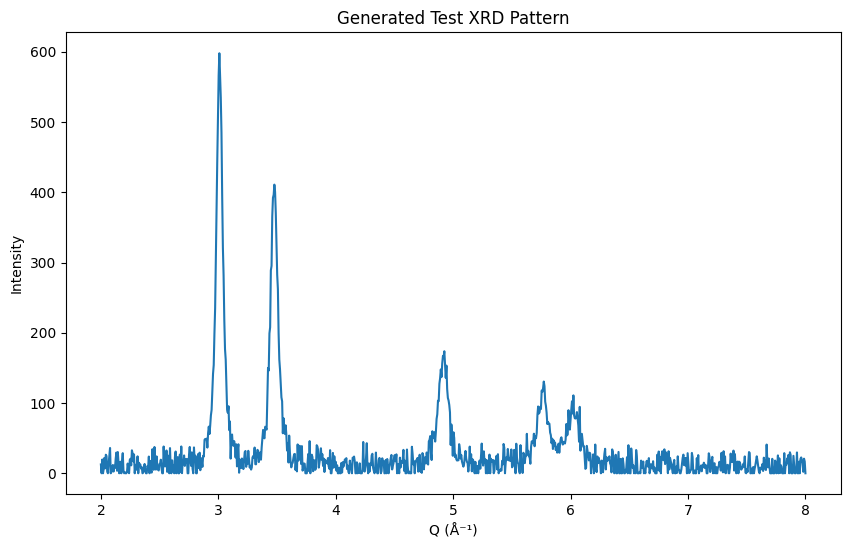

In [20]:
# Generate test data with custom parameters
lattice_params = {
    'a': 3.615,  # FCC aluminum
    'b': 3.615,
    'c': 3.615,
    'alpha': 90,
    'beta': 90,
    'gamma': 90
}

hkl_list = [
    (1, 1, 1),
    (2, 0, 0),
    (2, 2, 0),
    (3, 1, 1),
    (2, 2, 2)
]

q_data, intensity_data = generate_test_xrd_data(
    q_range=(2, 8),
    n_points=1000,
    lattice_params=lattice_params,
    hkl_list=hkl_list,
    peak_shape='pvoigt',
    noise_level=0.02,
    background_params=[10, -1, 0.1]
)

# Plot the test data
plt.figure(figsize=(10, 6))
plt.plot(q_data, intensity_data)
plt.xlabel('Q (Å⁻¹)')
plt.ylabel('Intensity')
plt.title('Generated Test XRD Pattern')
plt.show()

# Then proceed with fitting using the XRDAnalysis class as shown before

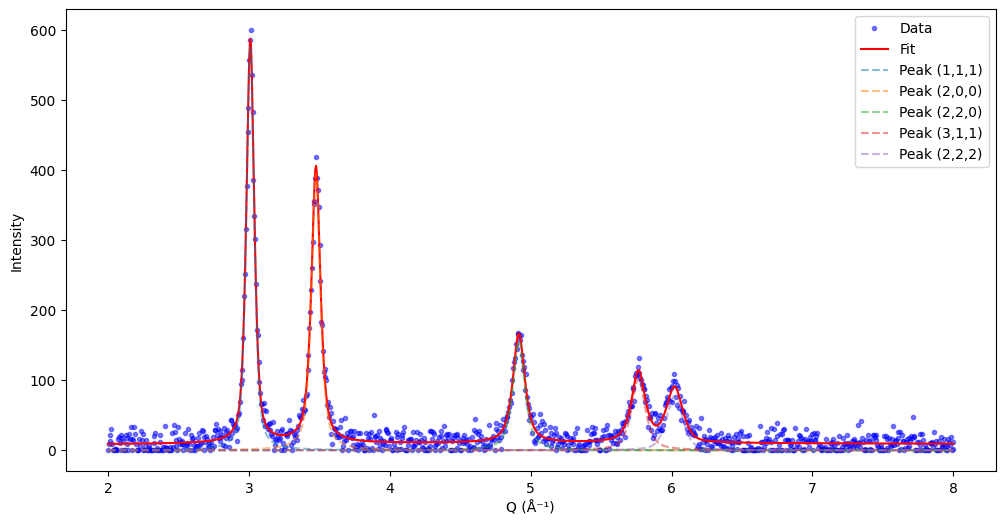


Fit Report:
[[Model]]
    Model(model_function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 170
    # data points      = 1000
    # variables        = 20
    chi-square         = 106629.059
    reduced chi-square = 108.805162
    Akaike info crit   = 4709.35607
    Bayesian info crit = 4807.51118
    R-squared          = 0.97592955
[[Variables]]
    a:            3.61481537 +/- 2.4874e-04 (0.01%) (init = 3.6)
    b:            3.61481537 +/- 2.4874e-04 (0.01%) == 'a'
    c:            3.61481537 +/- 2.4874e-04 (0.01%) == 'a'
    alpha:        90 (fixed)
    beta:         90 (fixed)
    gamma:        90 (fixed)
    amplitude_0:  576.948982 +/- 5.37071568 (0.93%) (init = 119.8682)
    sigma_0:      0.03023747 +/- 3.4593e-04 (1.14%) (init = 0.01)
    fraction_0:   0.41088740 +/- 0.04022911 (9.79%) (init = 0.5)
    amplitude_1:  395.033475 +/- 5.10231395 (1.29%) (init = 119.8682)
    sigma_1:      0.03537366 +/- 5.8405e-04 (1.65%) (init = 0.01)
    fractio

In [17]:
xrd = XRDAnalysis(q_data, intensity_data)

# Initial lattice parameters
initial_params = {
    'a': 3.6,  # Angstroms
    'b': 3.6,
    'c': 3.6,
    'alpha': 90,  # degrees
    'beta': 90,
    'gamma': 90
}

# Define constraints (example for cubic system)
constraints = {
    'b': 'a',  # b equals a
    'c': 'a',  # c equals a
    'alpha': 90,  # fix alpha at 90
    'beta': 90,  # fix beta at 90
    'gamma': 90  # fix gamma at 90
}

# Perform the fit
result = xrd.fit_pattern(
    hkl_list=hkl_list,
    initial_lattice_params=initial_params,
    peak_type='pvoigt',
    background_order=3,
    constraints=constraints
)

# Plot results
xrd.plot_results(result, show_components=True)

In [ ]:
result.model.

ValueError: max() iterable argument is empty

In [46]:
import numpy as np
from lmfit import Model, Parameters
import matplotlib.pyplot as plt

def calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma):
    """
    Calculate the interplanar spacing (d-spacing) for given Miller indices and lattice parameters.
    
    Parameters:
    h, k, l: Miller indices
    a, b, c: Lattice parameters (lengths in Angstroms)
    alpha, beta, gamma: Lattice angles in degrees
    
    Returns:
    d: Interplanar spacing in Angstroms
    """
    # Convert angles to radians
    alpha_rad, beta_rad, gamma_rad = np.radians([alpha, beta, gamma])
    
    # Calculate required terms
    cos_alpha, cos_beta, cos_gamma = np.cos([alpha_rad, beta_rad, gamma_rad])
    sin_alpha, sin_beta, sin_gamma = np.sin([alpha_rad, beta_rad, gamma_rad])
    
    # Calculate volume of unit cell
    V = a * b * c * np.sqrt(1 - cos_alpha**2 - cos_beta**2 - cos_gamma**2 + 2 * cos_alpha * cos_beta * cos_gamma)
    
    # Calculate S parameters (reciprocal metric tensor components)
    S11 = (b**2 * c**2 * sin_alpha**2) / V**2
    S22 = (a**2 * c**2 * sin_beta**2) / V**2
    S33 = (a**2 * b**2 * sin_gamma**2) / V**2
    S12 = (a * b * c**2 * (cos_alpha * cos_beta - cos_gamma)) / V**2
    S23 = (a**2 * b * c * (cos_gamma * cos_alpha - cos_beta)) / V**2
    S13 = (a * b**2 * c * (cos_beta * cos_gamma - cos_alpha)) / V**2
    
    # Calculate d-spacing
    d_inv_squared = (h**2 * S11 + k**2 * S22 + l**2 * S33 + 2 * h * k * S12 + 2 * k * l * S23 + 2 * h * l * S13)
    return 1 / np.sqrt(d_inv_squared)

def calc_xrd_peak_position(d_spacing):
    return 2 * np.pi / d_spacing

def create_peak_model(peak_type='gaussian'):
    if peak_type == 'gaussian':
        return lambda x, amplitude, center, sigma: amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))
    elif peak_type == 'lorentzian':
        return lambda x, amplitude, center, gamma: amplitude * gamma**2 / ((x - center)**2 + gamma**2)
    elif peak_type == 'pvoigt':
        def pvoigt(x, amplitude, center, sigma, fraction):
            g = np.exp(-(x - center)**2 / (2 * sigma**2))
            l = 1 / ((x - center)**2 + sigma**2)
            return amplitude * (fraction * g + (1 - fraction) * l)
        return pvoigt
    else:
        raise ValueError("Unsupported peak type")

def create_multi_peak_model(hkl_list, peak_type='gaussian'):
    def model(x, a, b, c, alpha, beta, gamma, *peak_params):
        print(peak_params)
        result = np.zeros_like(x)
        for i, (h, k, l) in enumerate(hkl_list):
            d = calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma)
            center = calc_xrd_peak_position(d)
            peak = create_peak_model(peak_type)
            if peak_type == 'pvoigt':
                result += peak(x, peak_params[i*3], center, peak_params[i*3+1], peak_params[i*3+2])
            else:
                result += peak(x, peak_params[i*2], center, peak_params[i*2+1])
        return result
    return model

def fit_xrd_data(x_data, y_data, hkl_list, initial_params, peak_type='gaussian', constraints=None):
    model = Model(create_multi_peak_model(hkl_list, peak_type))
    model.make_params()
    params = Parameters()

    # Add lattice parameters
    for param, value in initial_params.items():
        params.add(param, value=value, min=0)

    # Add peak parameters
    for i in range(len(hkl_list)):
        params.add(f'a_{i}', value=max(y_data)/len(hkl_list), min=0)
        params.add(f's_{i}', value=0.1, min=0)
        if peak_type == 'pvoigt':
            params.add(f'f_{i}', value=0.5, min=0, max=1)

    # Apply constraints
    if constraints:
        for constraint in constraints:
            if constraint[0] == 'fix':
                params[constraint[1]].vary = False
            elif constraint[0] == 'range':
                params[constraint[1]].min = constraint[2]
                params[constraint[1]].max = constraint[3]
            elif constraint[0] == 'equal':
                params[constraint[2]].expr = constraint[1]


    result = model.fit(y_data, params, x=x_data)
    return result

# Example usage
# Generate synthetic data
x = np.linspace(0, 10, 1000)
hkl_list = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
true_params = {'a': 3.6, 'b': 3.6, 'c': 3.6, 'alpha': 90, 'beta': 90, 'gamma': 90}
a, b, c, alpha, beta, gamma = true_params.values()

# Create the model function
model_func = create_multi_peak_model(hkl_list, 'gaussian')

# Generate synthetic data using the model function
peak_params = [1, 0.1, 0.8, 0.1, 0.6, 0.1]  # Amplitude and width for each peak
y = model_func(x, a, b, c, alpha, beta, gamma, *peak_params)
y += np.random.normal(0, 0.02, x.shape)  # Add some noise

# Fit the data
initial_params = {'a': 3.5, 'b': 3.5, 'c': 3.5, 'alpha': 90, 'beta': 90, 'gamma': 90}
constraints = [
    ('range', 'a', 3.4, 3.8),
    ('equal', 'a', 'b'),
    ('fix', 'alpha'),
    ('fix', 'beta'),
    ('fix', 'gamma')
]
result = fit_xrd_data(x, y, hkl_list, initial_params, 'gaussian', constraints)

# Print results
print(result.fit_report())

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b.', label='Data')
plt.plot(x, result.best_fit, 'r-', label='Fit')
plt.legend()
plt.xlabel('2θ')
plt.ylabel('Intensity')
plt.show()

(1, 0.1, 0.8, 0.1, 0.6, 0.1)


ValueError: varargs '*peak_params' is not supported

[[Model]]
    Model(model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 1000
    # variables        = 8
    chi-square         = 0.38467533
    reduced chi-square = 3.8778e-04
    Akaike info crit   = -7847.11089
    Bayesian info crit = -7807.84885
    R-squared          = 0.98803375
[[Variables]]
    a:             3.59951738 +/- 9.0176e-04 (0.03%) (init = 3.5)
    b:             3.59951738 +/- 9.0176e-04 (0.03%) == 'a'
    c:             3.60086896 +/- 0.00434294 (0.12%) (init = 3.5)
    alpha:         90 (fixed)
    beta:          90 (fixed)
    gamma:         90 (fixed)
    p1_amplitude:  1.00357871 +/- 0.00576616 (0.57%) (init = 0.3398757)
    p1_sigma:      0.09879957 +/- 6.5548e-04 (0.66%) (init = 0.1)
    p2_amplitude:  0.79639155 +/- 0.00573958 (0.72%) (init = 0.3398757)
    p2_sigma:      0.09976256 +/- 8.3086e-04 (0.83%) (init = 0.1)
    p3_amplitude:  0.59910957 +/- 0.00572009 (0.95%) (init = 0.3398757)
    p3_sig

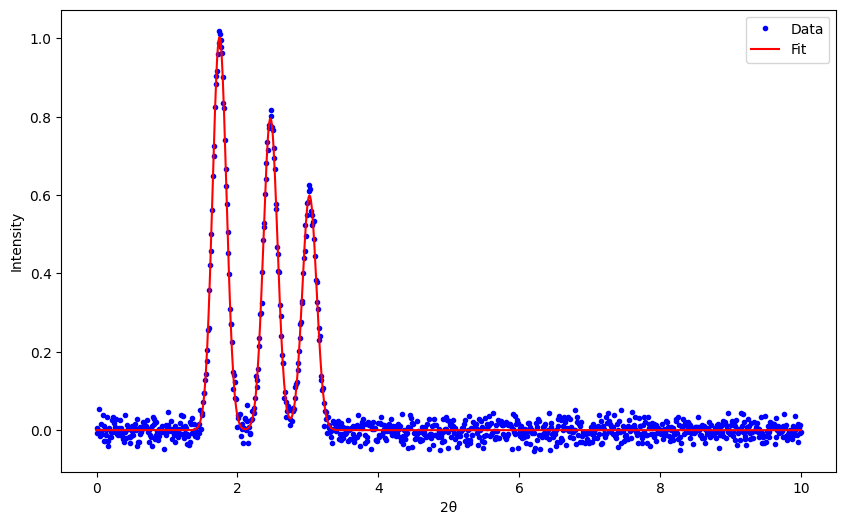

In [ ]:
import numpy as np
from lmfit import Model, Parameters
import matplotlib.pyplot as plt

def calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma):
    """
    Calculate the interplanar spacing (d-spacing) for given Miller indices and lattice parameters.
    
    Parameters:
    h, k, l: Miller indices
    a, b, c: Lattice parameters (lengths in Angstroms)
    alpha, beta, gamma: Lattice angles in degrees
    
    Returns:
    d: Interplanar spacing in Angstroms
    """
    # Convert angles to radians
    alpha_rad, beta_rad, gamma_rad = np.radians([alpha, beta, gamma])
    
    # Calculate required terms
    cos_alpha, cos_beta, cos_gamma = np.cos([alpha_rad, beta_rad, gamma_rad])
    sin_alpha, sin_beta, sin_gamma = np.sin([alpha_rad, beta_rad, gamma_rad])
    
    # Calculate volume of unit cell
    V = a * b * c * np.sqrt(1 - cos_alpha**2 - cos_beta**2 - cos_gamma**2 + 2 * cos_alpha * cos_beta * cos_gamma)
    
    # Calculate S parameters (reciprocal metric tensor components)
    S11 = (b**2 * c**2 * sin_alpha**2) / V**2
    S22 = (a**2 * c**2 * sin_beta**2) / V**2
    S33 = (a**2 * b**2 * sin_gamma**2) / V**2
    S12 = (a * b * c**2 * (cos_alpha * cos_beta - cos_gamma)) / V**2
    S23 = (a**2 * b * c * (cos_gamma * cos_alpha - cos_beta)) / V**2
    S13 = (a * b**2 * c * (cos_beta * cos_gamma - cos_alpha)) / V**2
    
    # Calculate d-spacing
    d_inv_squared = (h**2 * S11 + k**2 * S22 + l**2 * S33 + 2 * h * k * S12 + 2 * k * l * S23 + 2 * h * l * S13)
    return 1 / np.sqrt(d_inv_squared)

def calc_xrd_peak_position(d_spacing):
    return 2 * np.pi / d_spacing

def create_peak_model(peak_type='gaussian'):
    if peak_type == 'gaussian':
        return lambda x, amplitude, center, sigma: amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))
    elif peak_type == 'lorentzian':
        return lambda x, amplitude, center, gamma: amplitude * gamma**2 / ((x - center)**2 + gamma**2)
    elif peak_type == 'pvoigt':
        def pvoigt(x, amplitude, center, sigma, fraction):
            g = np.exp(-(x - center)**2 / (2 * sigma**2))
            l = 1 / ((x - center)**2 + sigma**2)
            return amplitude * (fraction * g + (1 - fraction) * l)
        return pvoigt
    else:
        raise ValueError("Unsupported peak type")

def create_multi_peak_model(hkl_list, peak_type='gaussian'):
    def model(x, a, b, c, alpha, beta, gamma, **peak_params):
        result = np.zeros_like(x)
        for i, (h, k, l) in enumerate(hkl_list):
            d = calculate_d_spacing(h, k, l, a, b, c, alpha, beta, gamma)
            center = calc_xrd_peak_position(d)
            peak = create_peak_model(peak_type)
            if peak_type == 'pvoigt':
                result += peak(x, peak_params[f'p{i+1}_amplitude'], center, peak_params[f'p{i+1}_sigma'], peak_params[f'p{i+1}_fraction'])
            else:
                result += peak(x, peak_params[f'p{i+1}_amplitude'], center, peak_params[f'p{i+1}_sigma'])
        return result
    return model

def fit_xrd_data(x_data, y_data, hkl_list, initial_params, peak_type='gaussian', constraints=None):
    model = Model(create_multi_peak_model(hkl_list, peak_type))
    params = Parameters()

    # Add lattice parameters
    for param, value in initial_params.items():
        params.add(param, value=value, min=0)

    # Add peak parameters
    for i in range(len(hkl_list)):
        params.add(f'p{i+1}_amplitude', value=max(y_data)/len(hkl_list), min=0)
        params.add(f'p{i+1}_sigma', value=0.1, min=0)
        if peak_type == 'pvoigt':
            params.add(f'p{i+1}_fraction', value=0.5, min=0, max=1)

    # Apply constraints
    if constraints:
        for constraint in constraints:
            if constraint[0] == 'fix':
                params[constraint[1]].vary = False
            elif constraint[0] == 'range':
                params[constraint[1]].min = constraint[2]
                params[constraint[1]].max = constraint[3]
            elif constraint[0] == 'equal':
                params[constraint[2]].expr = constraint[1]

    result = model.fit(y_data, params, x=x_data)
    return result

# Example usage
# Generate synthetic data
x = np.linspace(0, 10, 1000)
hkl_list = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
true_params = {'a': 3.6, 'b': 3.6, 'c': 3.6, 'alpha': 90, 'beta': 90, 'gamma': 90}
a, b, c, alpha, beta, gamma = true_params.values()

# Create the model function
model_func = create_multi_peak_model(hkl_list, 'gaussian')

# Generate synthetic data using the model function
peak_params = {'p1_amplitude':1, 'p1_sigma':0.1, 'p2_amplitude':0.8, 'p2_sigma':0.1, 'p3_amplitude':0.6, 'p3_sigma':0.1}  # Amplitude and width for each peak
y = model_func(x, **true_params, **peak_params)
y += np.random.normal(0, 0.02, x.shape)  # Add some noise

# Fit the data
initial_params = {'a': 3.5, 'b': 3.5, 'c': 3.5, 'alpha': 90, 'beta': 90, 'gamma': 90}
constraints = [
    ('range', 'a', 3.4, 3.8),
    ('equal', 'a', 'b'),
    ('fix', 'alpha'),
    ('fix', 'beta'),
    ('fix', 'gamma')
]
result = fit_xrd_data(x, y, hkl_list, initial_params, 'gaussian', constraints)

# Print results
print(result.fit_report())

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b.', label='Data')
plt.plot(x, result.best_fit, 'r-', label='Fit')
plt.legend()
plt.xlabel('2θ')
plt.ylabel('Intensity')
plt.show()